# **Проект: древесные алгоритмы**

### **Постановка задачи:**

У меня есть данные о полётах, где для каждого клиента известны его профиль, тип билета, характеристики рейса и оценки по разным аспектам перелёта. Для части клиентов также указана удовлетворённость — satisfied, neutral или dissatisfied.

Я построю модель, которая будет предсказывать уровень удовлетворённости на основе доступных признаков, и применю её для тех клиентов, для которых эта метка неизвестна.


In [211]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA**

## **1. 1. Загрузка и предобработка данных**

In [213]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-26 17:54:28--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-26 17:54:29 (2.31 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

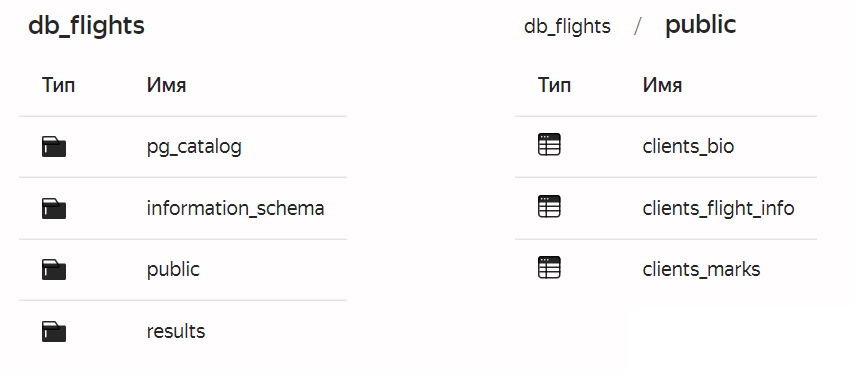



In [214]:
conn_params = {
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": 6432,
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student",
    "sslmode": "verify-full",
    "target_session_attrs": "read-write",
}

with psycopg2.connect(**conn_params) as conn:
    with conn.cursor() as cursor:
        cursor.execute('''
            SELECT table_name, column_name
            FROM information_schema.columns
            WHERE table_schema = 'public' AND table_name IN ('clients_bio', 'clients_flight_info', 'clients_marks');
        ''')
        table_structure = cursor.fetchall()
        for table, column in table_structure:
            print(f"Таблица: {table}, Столбец: {column}")

Таблица: clients_bio, Столбец: id
Таблица: clients_bio, Столбец: gender
Таблица: clients_bio, Столбец: age
Таблица: clients_flight_info, Столбец: id
Таблица: clients_flight_info, Столбец: Customer Type
Таблица: clients_flight_info, Столбец: Type of Travel
Таблица: clients_flight_info, Столбец: class
Таблица: clients_flight_info, Столбец: Flight Distance
Таблица: clients_flight_info, Столбец: Departure Delay in Minutes
Таблица: clients_flight_info, Столбец: Arrival Delay in Minutes
Таблица: clients_marks, Столбец: id
Таблица: clients_marks, Столбец: Inflight wifi service
Таблица: clients_marks, Столбец: Departure/Arrival time convenient
Таблица: clients_marks, Столбец: Ease of Online booking
Таблица: clients_marks, Столбец: Gate location
Таблица: clients_marks, Столбец: Food and drink
Таблица: clients_marks, Столбец: Online boarding
Таблица: clients_marks, Столбец: Seat comfort
Таблица: clients_marks, Столбец: Inflight entertainment
Таблица: clients_marks, Столбец: On-board service
Табл

In [215]:
query = '''
    SELECT
        cb.id,
        cb.gender,
        cb.age,
        cfi."Customer Type",
        cfi."Type of Travel",
        cfi.class,
        cfi."Flight Distance",
        cfi."Departure Delay in Minutes",
        cfi."Arrival Delay in Minutes",
        cm."Inflight wifi service",
        cm."Departure/Arrival time convenient",
        cm."Ease of Online booking",
        cm."Gate location",
        cm."Food and drink",
        cm."Online boarding",
        cm."Seat comfort",
        cm."Inflight entertainment",
        cm."On-board service",
        cm."Leg room service",
        cm."Baggage handling",
        cm."Checkin service",
        cm."Inflight service",
        cm.cleanliness,
        cm.satisfaction
    FROM public.clients_bio AS cb
    JOIN public.clients_flight_info AS cfi ON cb.id = cfi.id
    JOIN public.clients_marks AS cm ON cb.id = cm.id;
'''

with psycopg2.connect(**conn_params) as conn:
    df = pd.read_sql_query(query, conn)

df.set_index('id', inplace=True)

<ipython-input-215-21461d06b772>:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [216]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [217]:
assert df.shape == (129_549, 23)

Я преобразую все числовые столбцы в тип float, а затем проверю датафрейм на наличие пропусков и выбросов — как в числовых, так и в категориальных признаках.

In [218]:
# Преобразуем числовые столбцы в тип float
col_not_float = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']

for col in df.columns:
    if col not in col_not_float:
        df[col] = df[col].astype(float)

In [219]:
# Смотрим на количество пропусков в каждом столбце
df.isna().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

Как мы видим, пропуски есть почти ведзе. Теперь посмотрим на выбросы. Сгачала в числовых столбцах.

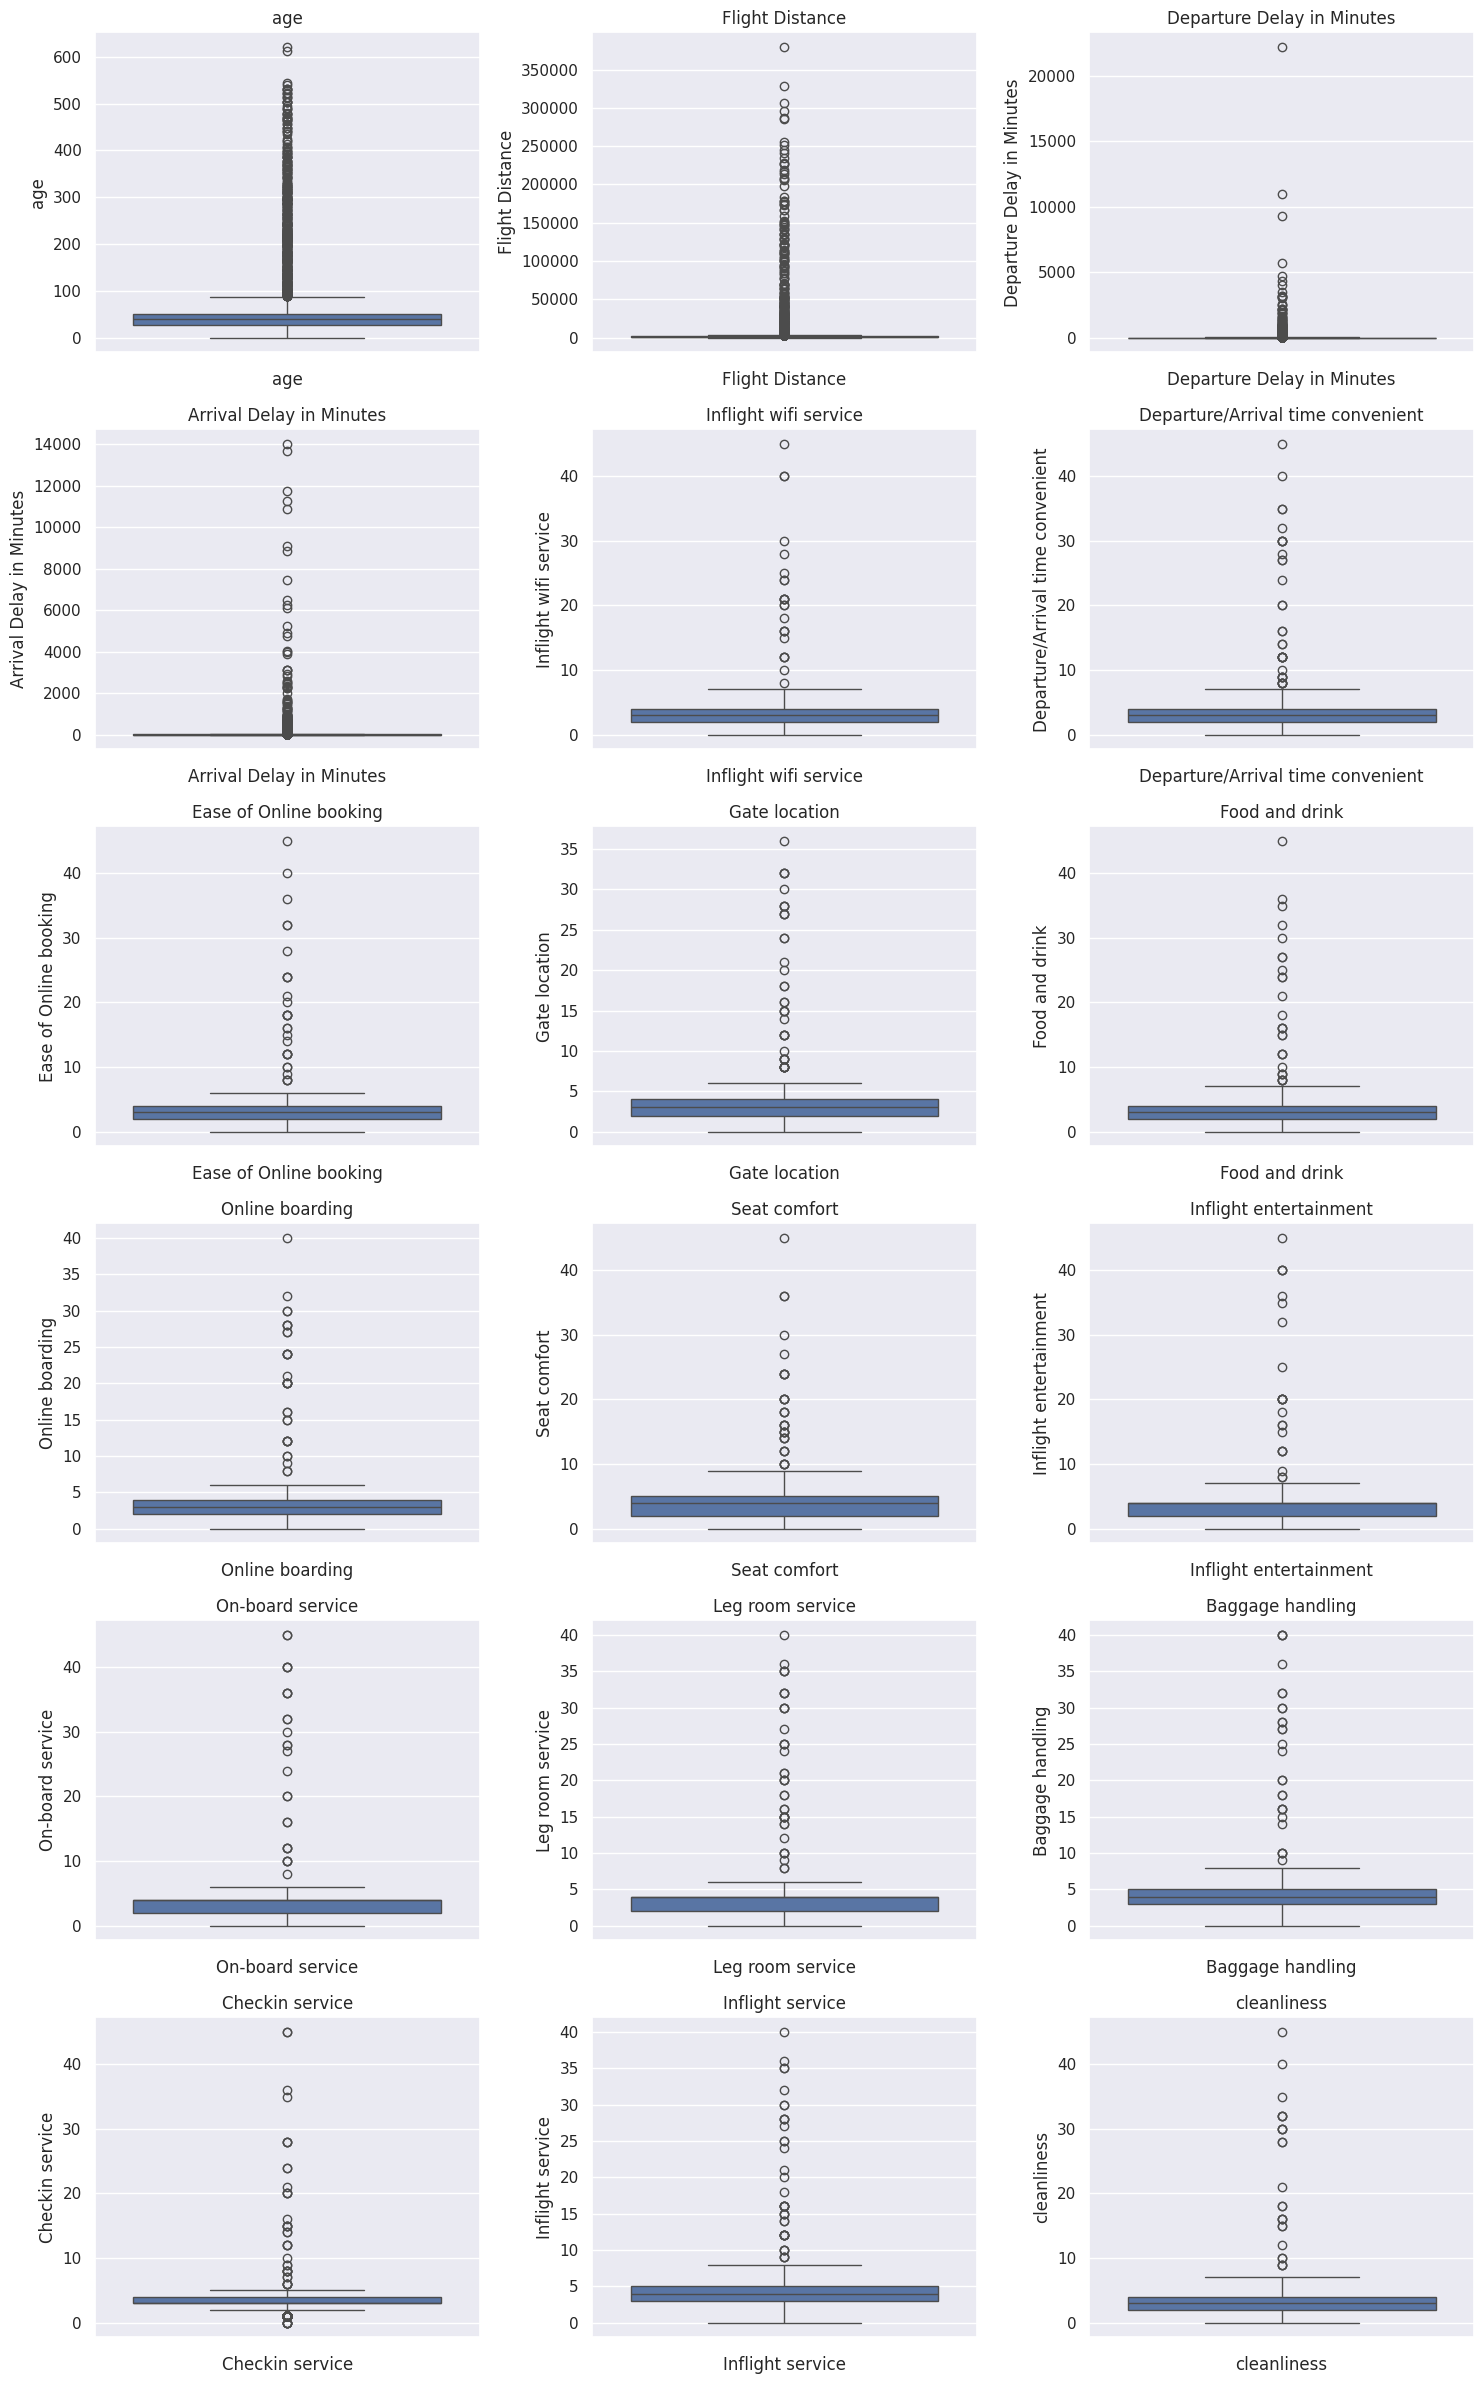

In [220]:
float_cols = [col for col in df.columns if col not in col_not_float]
# Определяем количество строк и столбцов для графиков
num_plots = len(float_cols)
num_rows = (num_plots + 2) // 3

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(float_cols):
    sns.boxplot(data=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

Как мы видим на ргафиках, выбросов для каждой категории тоже достаточно. Найдем теперь их количество.

In [221]:
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

for col in float_cols:
    outliers = find_outliers_iqr(df[col])
    print(f'Столбец {col} с {len(outliers)} выбросами')

Столбец age с 448 выбросами
Столбец Flight Distance с 3074 выбросами
Столбец Departure Delay in Minutes с 18124 выбросами
Столбец Arrival Delay in Minutes с 17499 выбросами
Столбец Inflight wifi service с 24 выбросами
Столбец Departure/Arrival time convenient с 35 выбросами
Столбец Ease of Online booking с 29 выбросами
Столбец Gate location с 39 выбросами
Столбец Food and drink с 28 выбросами
Столбец Online boarding с 32 выбросами
Столбец Seat comfort с 34 выбросами
Столбец Inflight entertainment с 23 выбросами
Столбец On-board service с 26 выбросами
Столбец Leg room service с 39 выбросами
Столбец Baggage handling с 27 выбросами
Столбец Checkin service с 16103 выбросами
Столбец Inflight service с 39 выбросами
Столбец cleanliness с 25 выбросами


In [222]:
# Посмотрим на уникальные значения в категориальных переменных (выбросы)
for col in col_not_float:
    print(f'Выбросы для {col}\n {df[col].unique()}\n')

Выбросы для gender
 ['Male' 'Female']

Выбросы для Customer Type
 ['Loyal Customer' 'disloyal Customer' 'nan']

Выбросы для Type of Travel
 ['Business travel' 'Personal Travel' 'nan']

Выбросы для class
 ['Business' 'Eco' 'Eco Plus' 'nan']

Выбросы для satisfaction
 ['satisfied' 'neutral or dissatisfied' '-']



Как мы видим, выбросов нет только для гендера, а в остальных столбцах есть пропуски.

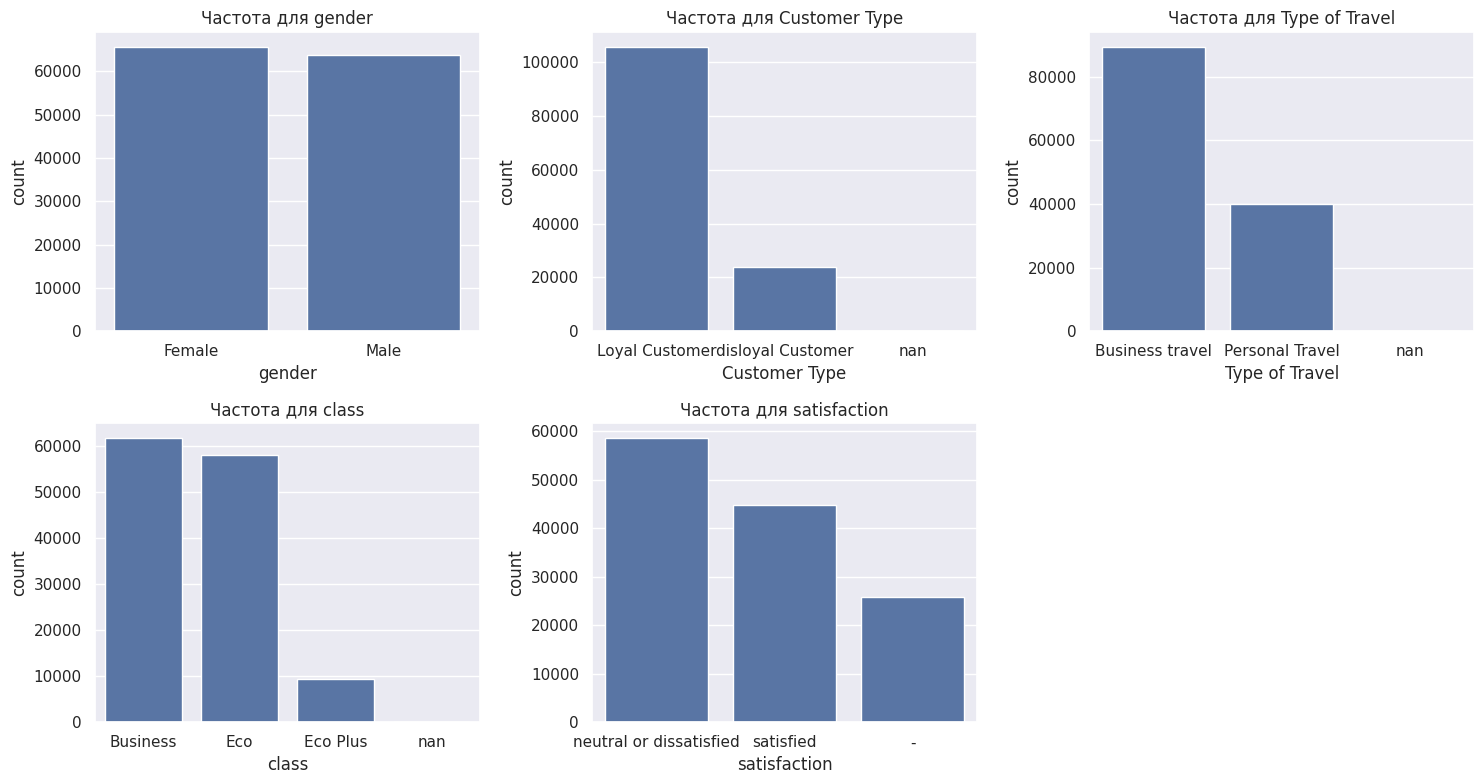

In [223]:
num_plots = len(col_not_float)
num_rows = (num_plots + 2) // 3

# Создаем сетку графиков
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(col_not_float):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Частота для {col}')
    axes[i].set_xlabel(col)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Я воспользуюсь модулем missingno для визуализации пропусков:

построю matrix — тепловую карту пропущенных значений;
а также столбчатую диаграмму количества пропусков по столбцам в логарифмированной шкале, чтобы чётко увидеть, в каких признаках пропусков больше, несмотря на их малое общее количество.

<Axes: >

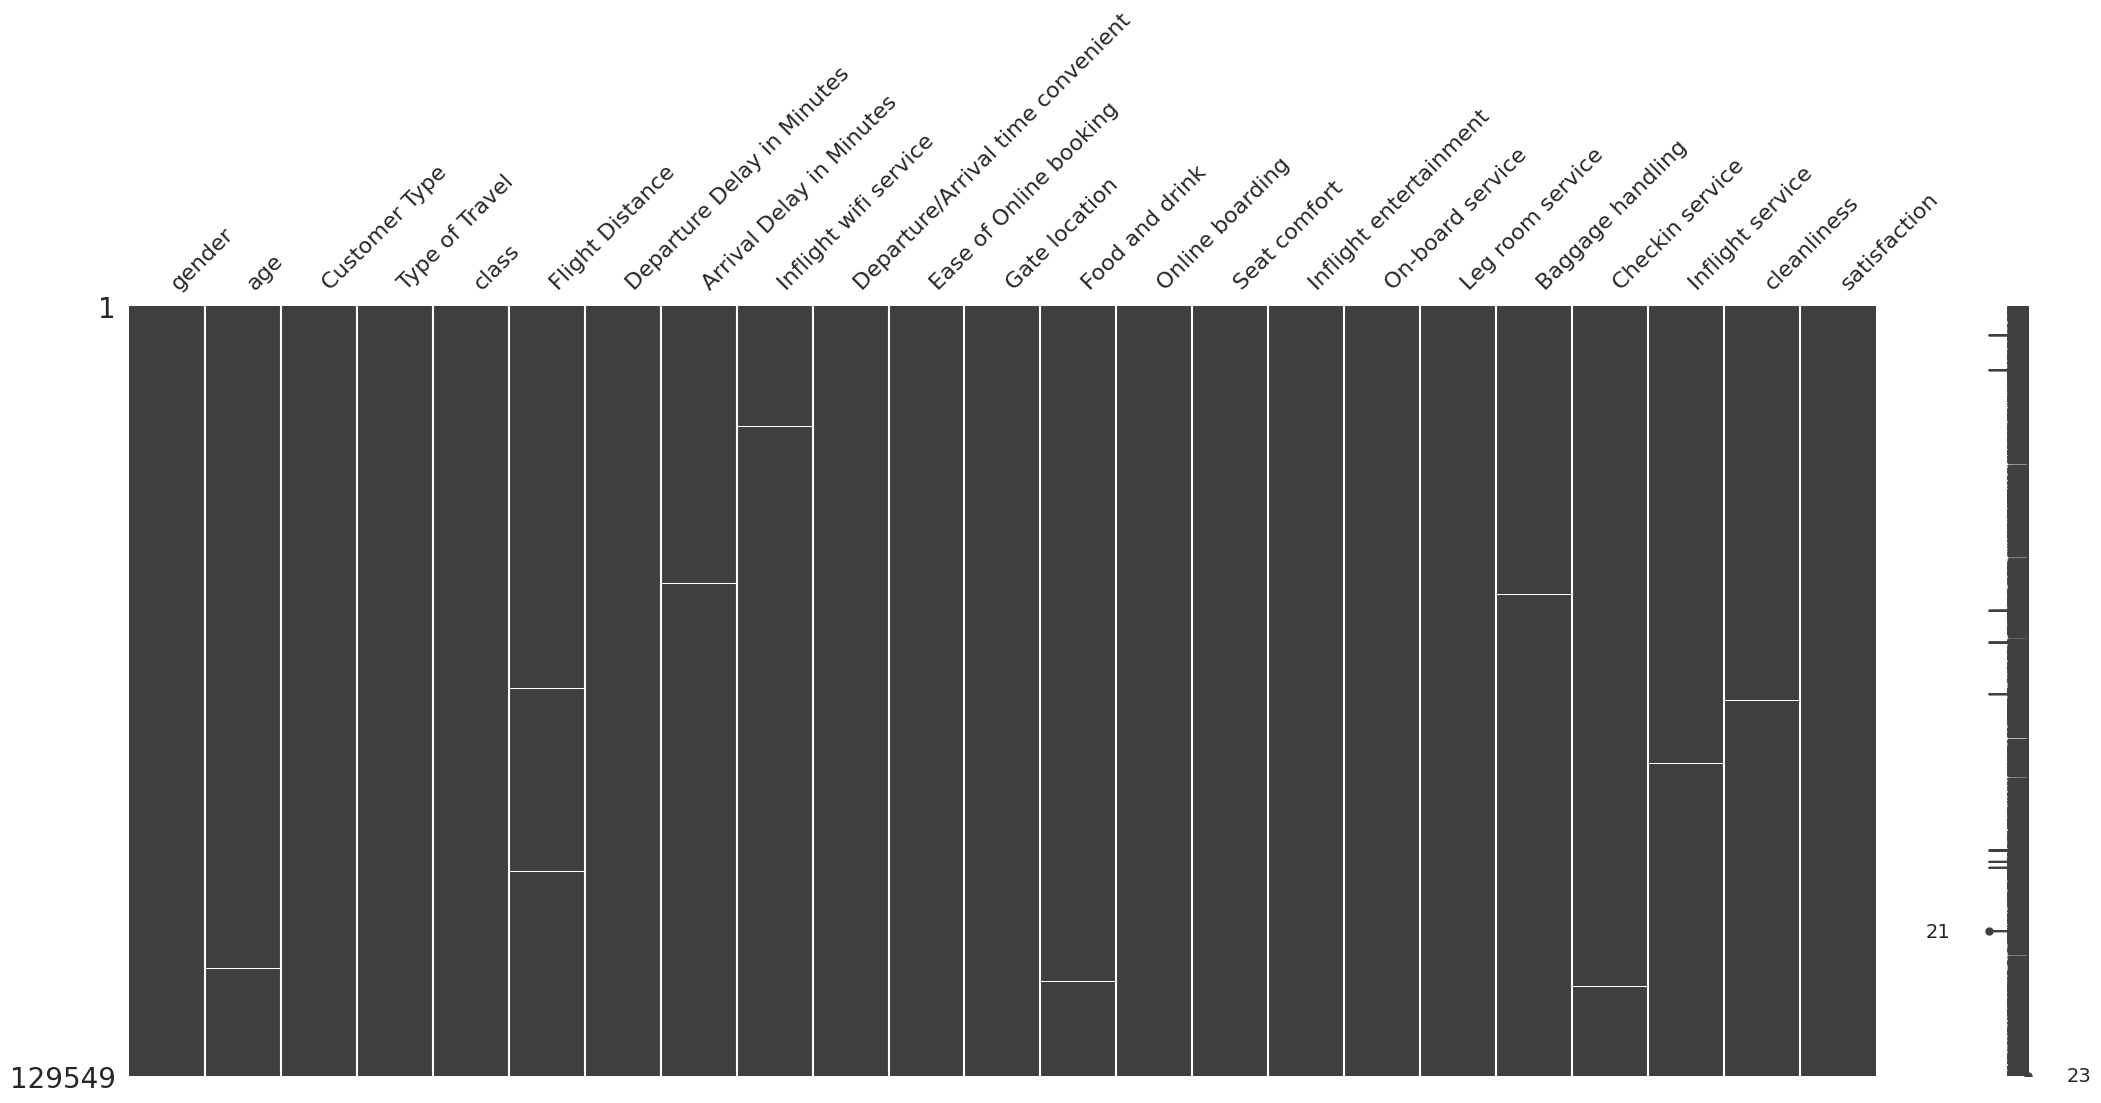

In [224]:
# matrix пропущенных значений
sns.set()
msno.matrix(df)

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

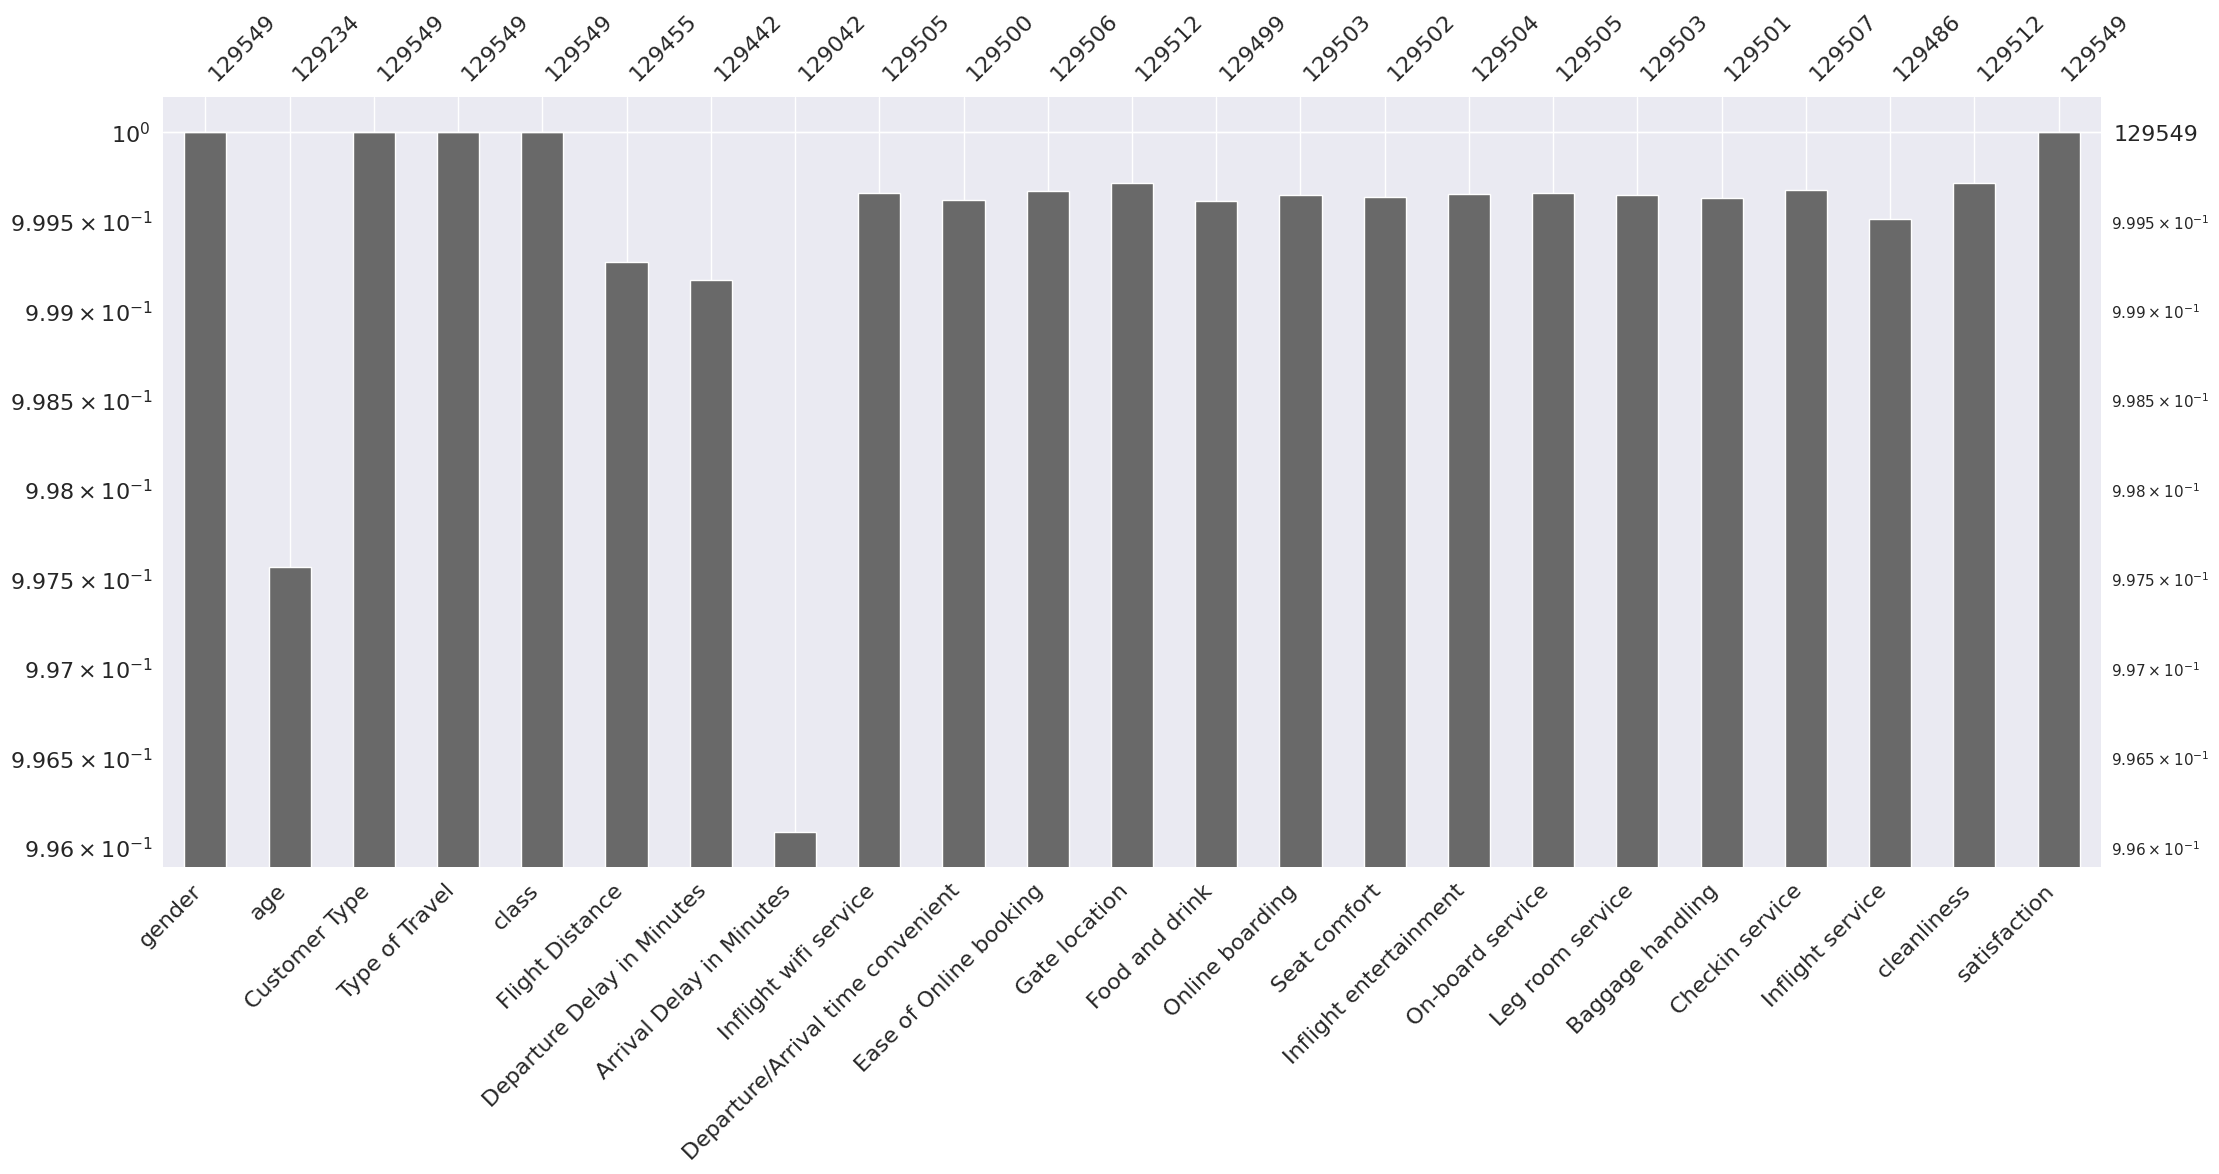

In [225]:
msno.bar(df, log=True)

Как можно заметить, самое большое количество пропусков у нас только в двух столбцах: age и Arrival Delay in Minutes

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [226]:
df_train = df[df.satisfaction != '-']
df_train.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

    Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
7            1963.0                         0.0                       0.0   
13            453.0                        16.0                      30.0   
18            821.0                         0.0                       0.0   
31            212.0                         0.0                       0.0   
39             67.0                         0.0                       0.0   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                            ...   
7                     3.0                                3.0  ...   
13                    2.0                                2.0  ...   
18                    2.0                                5.0  ...   
31                    2.0                                2.0  ...   
39                    3.0                                3.0  ...   

    Online boarding  Seat comfort  Inflight entertainment  On-board service  \
id                                                                            
7               4.0           5.0                     5.0               5.0   
13              2.0           5.0                     5.0               2.0   
18              1.0           5.0                     5.0               5.0   
31              2.0           2.0                     2.0               4.0   
39              5.0           4.0                     4.0               4.0   

    Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                          
7                5.0               5.0              4.0               5.0   
13               4.0               4.0              2.0               4.0   
18               2.0               5.0              5.0               5.0   
31               5.0               5.0              5.0               4.0   
39               4.0               4.0              5.0               4.0   

    cleanliness             satisfaction  
id                                        
7           4.0                satisfied  
13          5.0  neutral or dissatisfied  
18          1.0  neutral or dissatisfied  
31          2.0  neutral or dissatisfied  
39          5.0                satisfied  

[5 rows x 23 columns]

In [227]:
assert df_train.shape == (103_644, 23)

In [228]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
id                                                                              
55     Male  36.0  Loyal Customer  Business travel  Business           3655.0   
79   Female  70.0  Loyal Customer  Personal Travel       Eco            108.0   
126    Male  66.0  Loyal Customer  Personal Travel       Eco            562.0   
199  Female  60.0  Loyal Customer  Business travel  Business           3756.0   
263    Male  43.0  Loyal Customer  Personal Travel  Business            802.0   

     Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                          
55                         40.0                      71.0   
79                         50.0                      41.0   
126                        88.0                      84.0   
199                        36.0                      24.0   
263                         0.0                       0.0   

     Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                             ...   
55                     1.0                                1.0  ...   
79                     5.0                                4.0  ...   
126                    2.0                                5.0  ...   
199                    4.0                                4.0  ...   
263                    1.0                                2.0  ...   

     Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                           
55              1.0              3.0           3.0                     3.0   
79              4.0              4.0           4.0                     3.0   
126             5.0              2.0           5.0                     5.0   
199             2.0              4.0           5.0                     4.0   
263             2.0              3.0           3.0                     2.0   

     On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                           
55                3.0               3.0               1.0              4.0   
79                3.0               0.0               3.0              5.0   
126               3.0               5.0               2.0              5.0   
199               4.0               4.0               4.0              5.0   
263               2.0               1.0               2.0              3.0   

     Inflight service  cleanliness  
id                                  
55                3.0          2.0  
79                3.0          5.0  
126               5.0          5.0  
199               4.0          5.0  
263               2.0          1.0  

[5 rows x 22 columns]

In [229]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [230]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [231]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

Я заполню пропуски в данных наиболее часто встречающимся значением (модой), обучив импьютер только на тренировочной выборке и применив его к обеим выборкам — чтобы избежать утечки данных.

Учту, что в нашей задаче все признаки целочисленные, поэтому более сложные методы вроде KNNImputer или IterativeImputer не подходят — они возвращают вещественные значения и нарушают семантику признаков.

In [232]:
for col in df.columns[df.isnull().any()]:
    mode_values = df_train[col].mode().iloc[0]
    # Замена NaN значений
    for dataset in [df_test, X_train, X_val]:
        dataset[col].fillna(mode_values, inplace=True)

<ipython-input-232-3baa94af3b7d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(mode_values, inplace=True)


In [233]:
col_not_float.remove('satisfaction')

In [234]:
for col in col_not_float:
    mode_values = df_train[col].mode().iloc[0]
    for dataset in [df_test, X_train, X_val]:
        # Замена строковых 'nan'
        ind = dataset[col][dataset[col] == 'nan'].index.tolist()
        for i in ind:
            dataset[col][i] = mode_values

<ipython-input-234-618379f99cf9>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset[col][i] = mode_values
<ipython-input-234-618379f99cf9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

In [235]:
for col in col_not_float:
    print(f'Выбросы для {col}\n {X_train[col].unique()}\n')

Выбросы для gender
 ['Female' 'Male']

Выбросы для Customer Type
 ['disloyal Customer' 'Loyal Customer']

Выбросы для Type of Travel
 ['Business travel' 'Personal Travel']

Выбросы для class
 ['Business' 'Eco' 'Eco Plus']



In [236]:
X_train.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

При заполнении пропусков модой в разбитом датасете следую принципу "использовать только информацию из обучающего набора данных (train)" . Это делается для того, чтобы избежать утечки информации.

Я выведу основные статистики по числовым и категориальным столбцам таблицы и сделаю текстовый вывод о том, как распределены значения признаков — включая типичные значения, разброс, наличие дисбаланса (в категориальных признаках) и возможные аномалии.

In [237]:
# Основные статистики по числовым столбцам
df.describe().round(2)

age  Flight Distance  Departure Delay in Minutes  \
count  129234.00        129455.00                   129442.00   
mean       40.12          1322.92                       15.81   
std        20.38          4517.82                       93.28   
min         0.00             0.00                        0.00   
25%        27.00           414.00                        0.00   
50%        40.00           846.00                        0.00   
75%        51.00          1744.00                       12.00   
max       621.00        379620.00                    22227.00   

       Arrival Delay in Minutes  Inflight wifi service  \
count                 129042.00              129505.00   
mean                      16.66                   2.73   
std                      109.29                   1.36   
min                        0.00                   0.00   
25%                        0.00                   2.00   
50%                        0.00                   3.00   
75%                       13.00                   4.00   
max                    14006.00                  45.00   

       Departure/Arrival time convenient  Ease of Online booking  \
count                          129500.00               129506.00   
mean                                3.06                    2.76   
std                                 1.56                    1.43   
min                                 0.00                    0.00   
25%                                 2.00                    2.00   
50%                                 3.00                    3.00   
75%                                 4.00                    4.00   
max                                45.00                   45.00   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count      129512.00       129499.00        129503.00     129502.00   
mean            2.98            3.21             3.26          3.45   
std             1.31            1.36             1.38          1.35   
min             0.00            0.00             0.00          0.00   
25%             2.00            2.00             2.00          2.00   
50%             3.00            3.00             3.00          4.00   
75%             4.00            4.00             4.00          5.00   
max            36.00           45.00            40.00         45.00   

       Inflight entertainment  On-board service  Leg room service  \
count               129504.00         129505.00         129503.00   
mean                     3.36              3.39              3.36   
std                      1.37              1.34              1.36   
min                      0.00              0.00              0.00   
25%                      2.00              2.00              2.00   
50%                      4.00              4.00              4.00   
75%                      4.00              4.00              4.00   
max                     45.00             45.00             40.00   

       Baggage handling  Checkin service  Inflight service  cleanliness  
count         129501.00        129507.00         129486.00    129512.00  
mean               3.64             3.31              3.65         3.29  
std                1.22             1.30              1.22         1.35  
min                0.00             0.00              0.00         0.00  
25%                3.00             3.00              3.00         2.00  
50%                4.00             3.00              4.00         3.00  
75%                5.00             4.00              5.00         4.00  
max               40.00            45.00             40.00        45.00

In [238]:
# Основные статистики по категориальным столбцам
df.describe(include=object)

gender   Customer Type   Type of Travel     class  \
count   129549          129549           129549    129549   
unique       2               3                3         4   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

**Основыне статистики для категориальных переменных:**\
В этих данных ничего особого, кроме наличия пустых значений или пропусков.\
**Основыне статистики для числовых переменных:**\
Тут хотелось бы обратить внимание на первые 4 столбца


 age - на первый взгляд ничего особого. Стандартное отклонение и средний возраст выглядят нормально. Минимальный возраст - это, возможно, дети до года, но значение максимального возраста слишком велико, что похоже на выброс.\
Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes- здесь опять же, максимальные значения слишков велики, что похоже на выбросы (и это видно выше по ящику с усами)



Я удалю строки с выбросами в числовых столбцах обучающей и валидационной выборок, оставив тестовую выборку без изменений.
Выбросами буду считать значения, строго превышающие 0.996-квантиль по каждому числовому признаку — то есть те, что попадают в верхние 0.4 % распределения.


In [239]:
X_train.shape

(72550, 22)

In [240]:
def remove_outlier(data):
    numeric_cols = data.select_dtypes(include=['number'])
    quantiles = numeric_cols.quantile(0.996)
    outliers = (numeric_cols > quantiles).any(axis=1)
    return data[~outliers]


X_train = remove_outlier(X_train)
X_val = remove_outlier(X_val)

# Для y_train и y_val удаляем соответствующие строки
y_train = y_train[X_train.index]
y_val = y_val[X_val.index]

In [241]:
X_train.shape

(71395, 22)

Нужные выбросы были удалены. Размер тренировочного датасета уменьшился

In [242]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA**

Создадим переменные с перечислениями столбцов разного типа

In [243]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [244]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

Я напишу три процедуры для визуализации:

* для порядковых и категориальных признаков — countplot,
* для непрерывных — гистограмму и boxplot («ящик с усами»), размещённые inline.

Все графики будут корректно подписаны: с заголовками, подписями осей и легендой.

Затем я применю эти процедуры ко всем соответствующим столбцам в X_train и отдельно визуализирую распределение таргета в трейне, выделив удовлетворённых и недовольных клиентов разными цветами — чтобы наглядно увидеть, чем они отличаются.

In [245]:
target_colors = {'satisfied': 'green', 'neutral or dissatisfied': 'red'}

На графиках зеленым отметим удовлетворенных клиентов, а красным нейтральных или недовольных.

In [246]:
def plot_ordinal(cols, df, y):
    """
    Draws countplots for all columns in 'cols' with informative title
    """
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, hue=y, palette=target_colors)
        plt.title(f'Распределение значений {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.legend(title='Target')
        plt.show()

In [247]:
def plot_continuous(cols, df, y):
    """
    Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        sns.kdeplot(data=df, x=col, hue=y, fill=True, ax=axes[0], palette=target_colors)
        axes[0].set_title(f'Распределение {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Плотность')

        sns.boxplot(data=df, x=y, y=col, hue=y, palette=target_colors, ax=axes[1], legend=False)
        axes[1].set_title(f'Ящик с усами для {col}')
        axes[1].set_xlabel('Target')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

In [248]:
def plot_categorical(cols, df, y):
    """
    Draws countplots for all columns in 'cols' with informative title
    """
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, hue=y, palette=target_colors)
        plt.title(f'Распределение значений {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.legend(title='Target')
        plt.show()

Отрисовка.

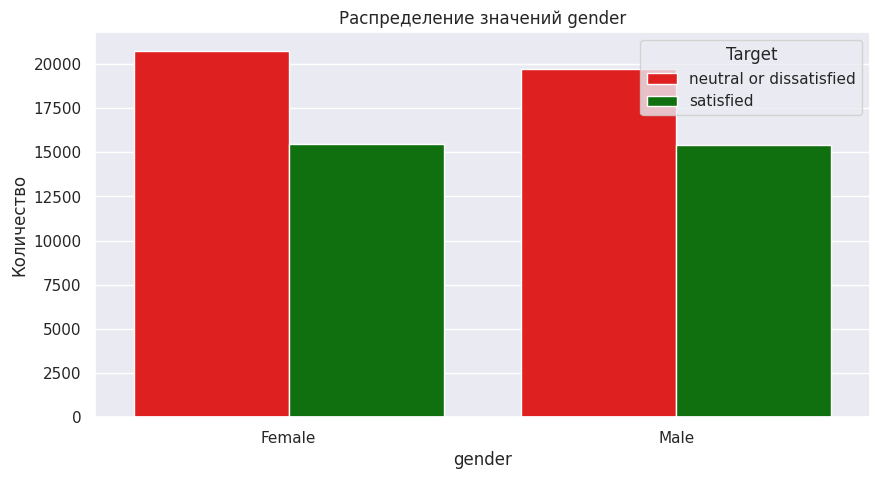

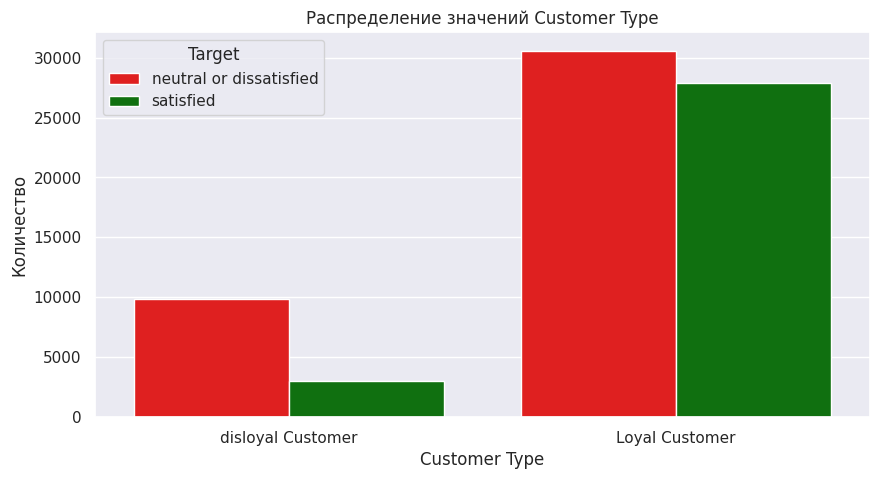

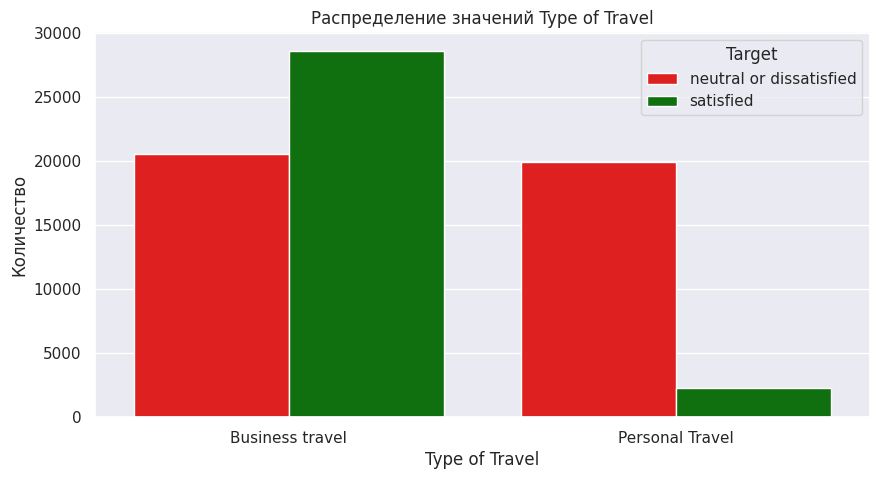

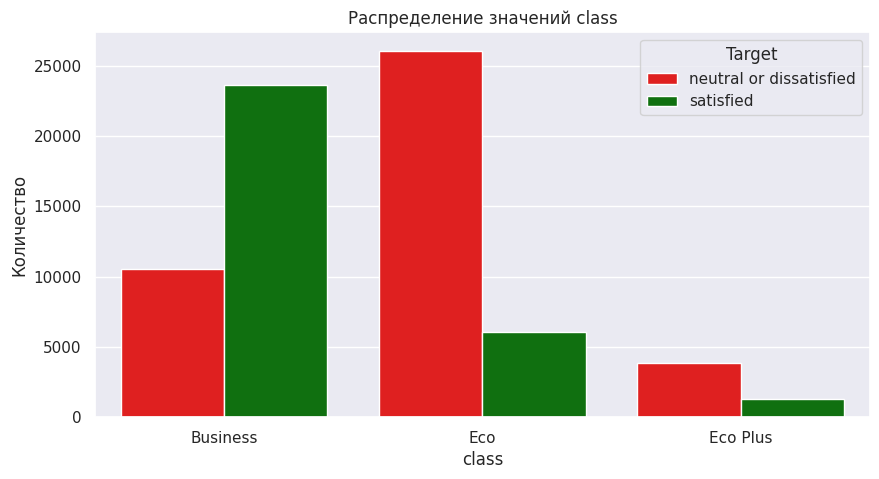

In [249]:
plot_categorical(categorical_cols, X_train, y_train)

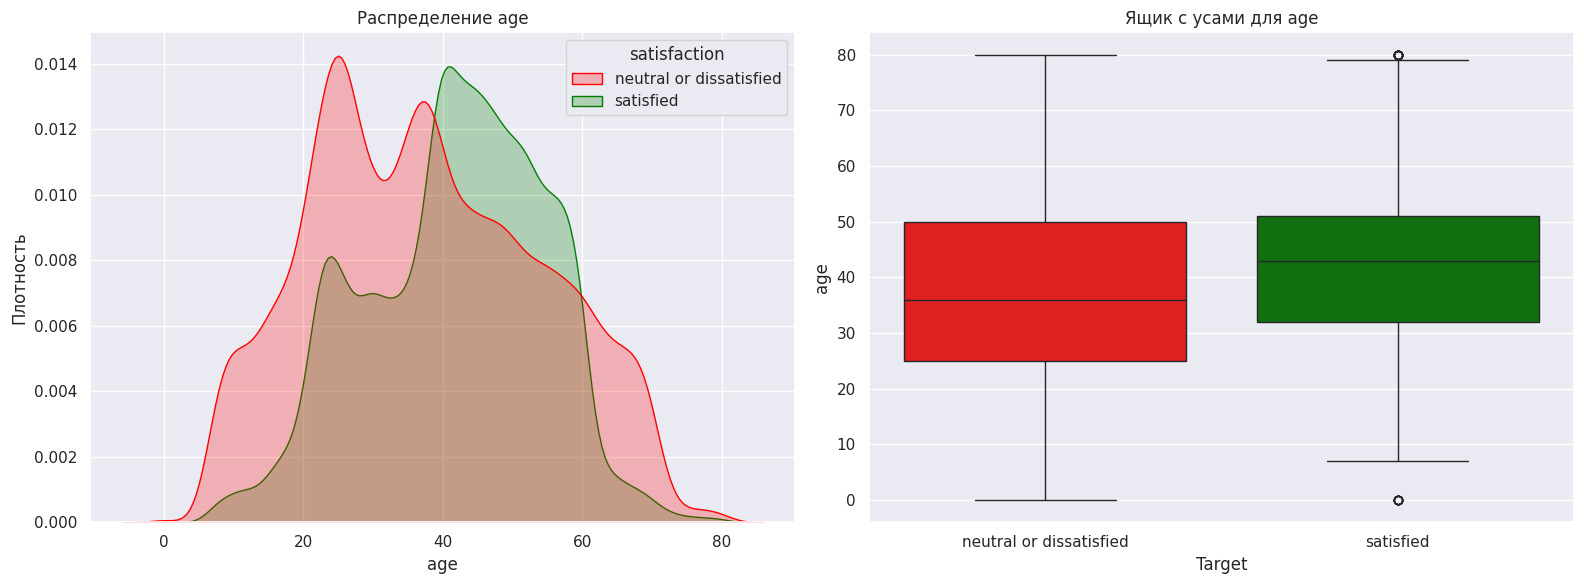

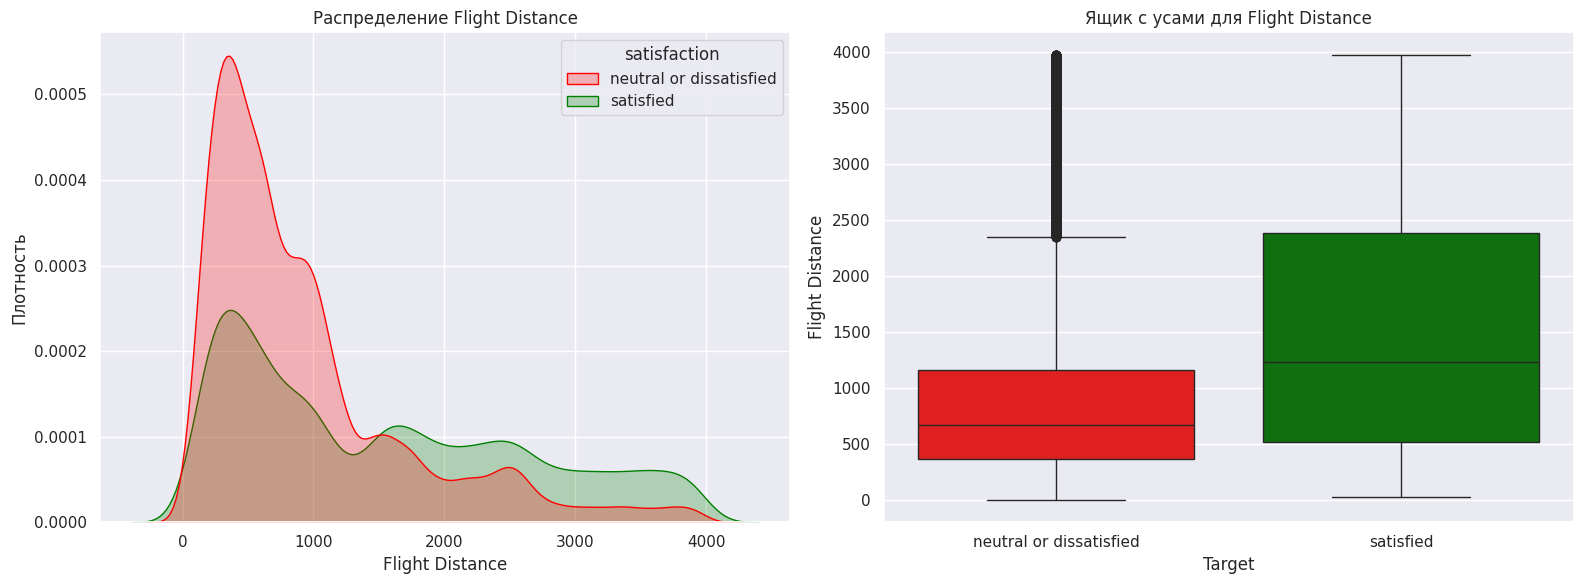

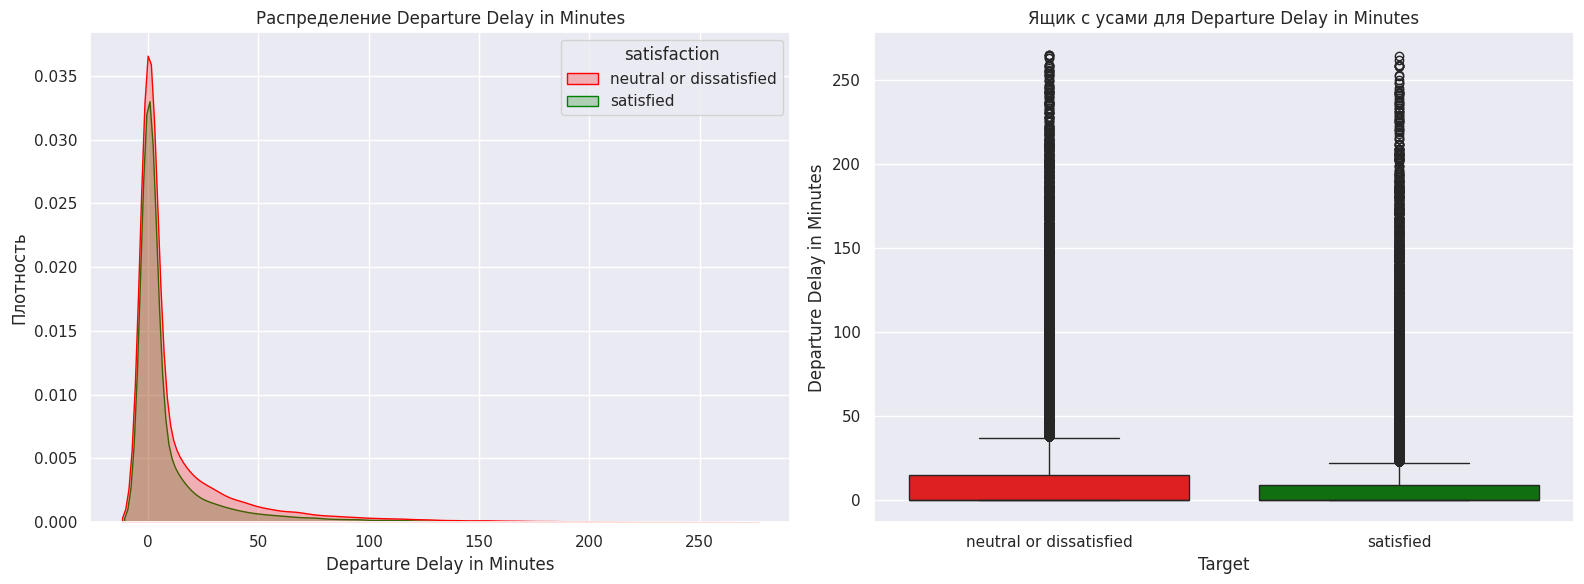

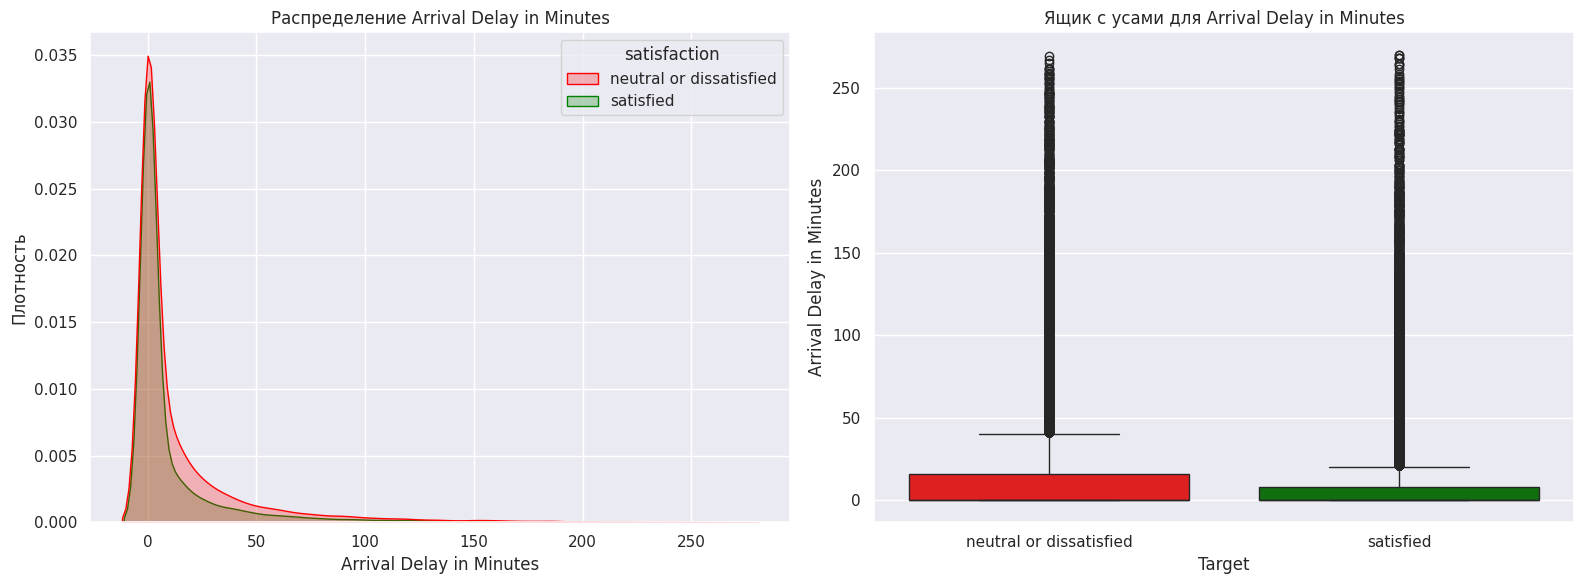

In [250]:
plot_continuous(continuous_cols, X_train, y_train)

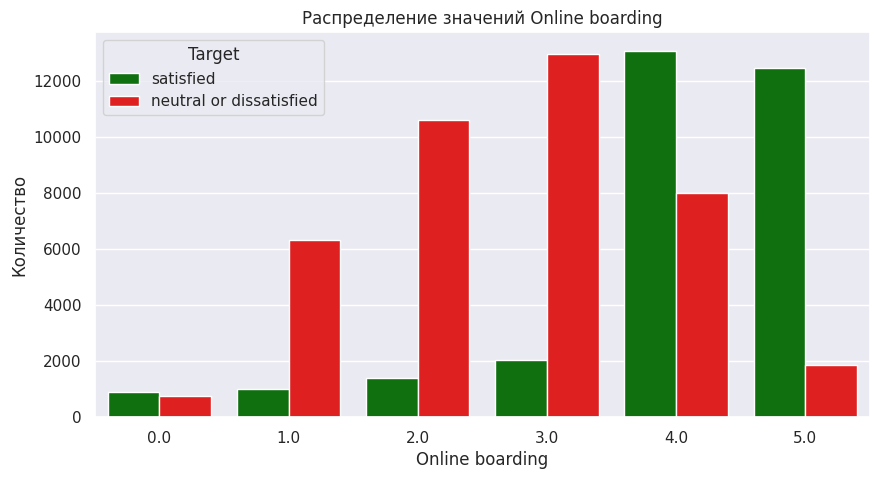

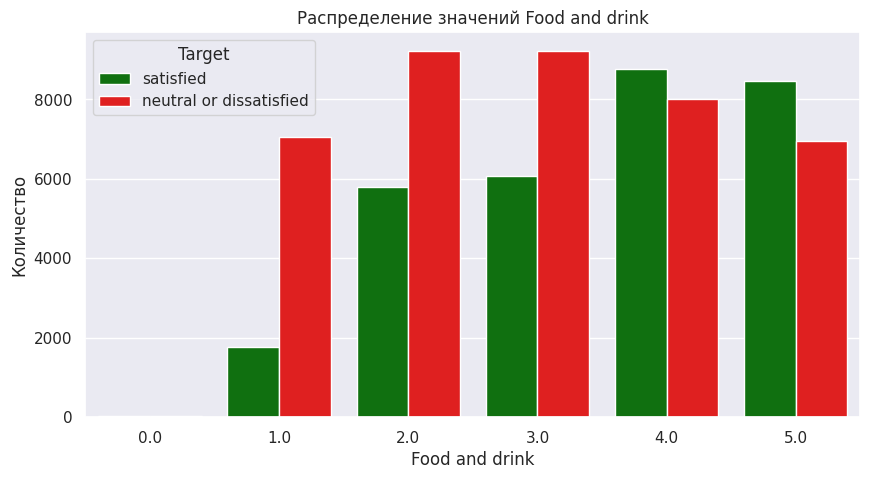

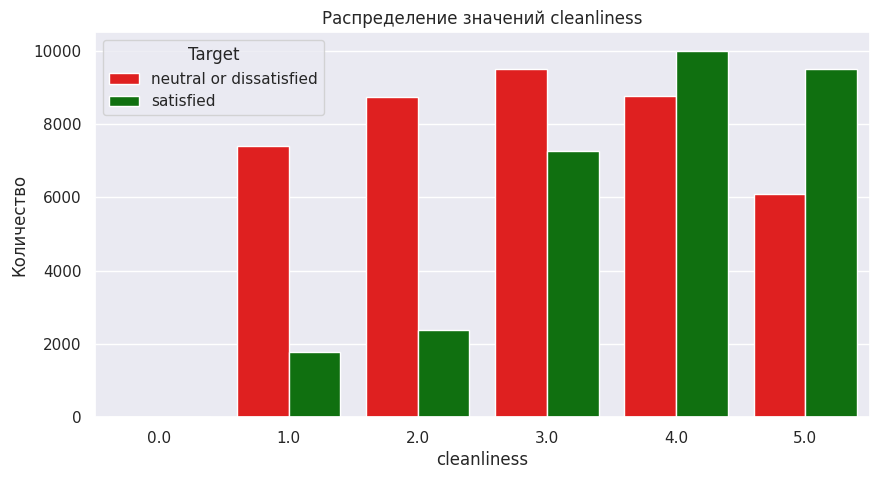

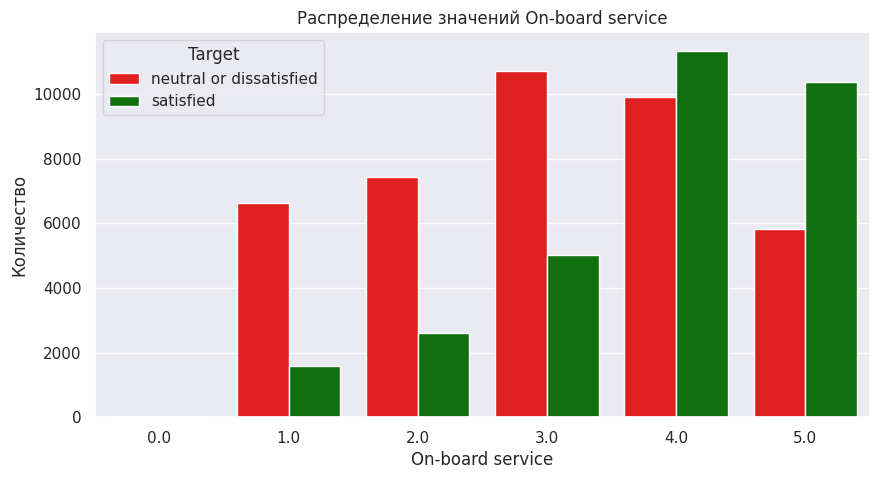

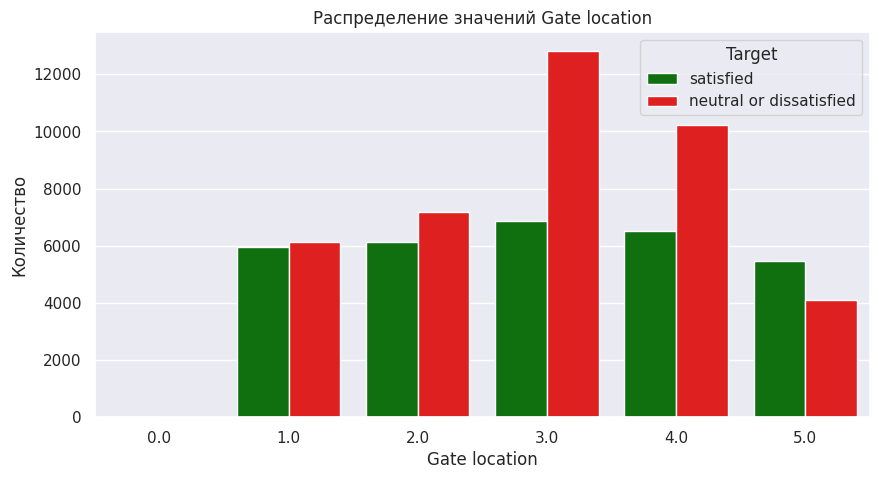

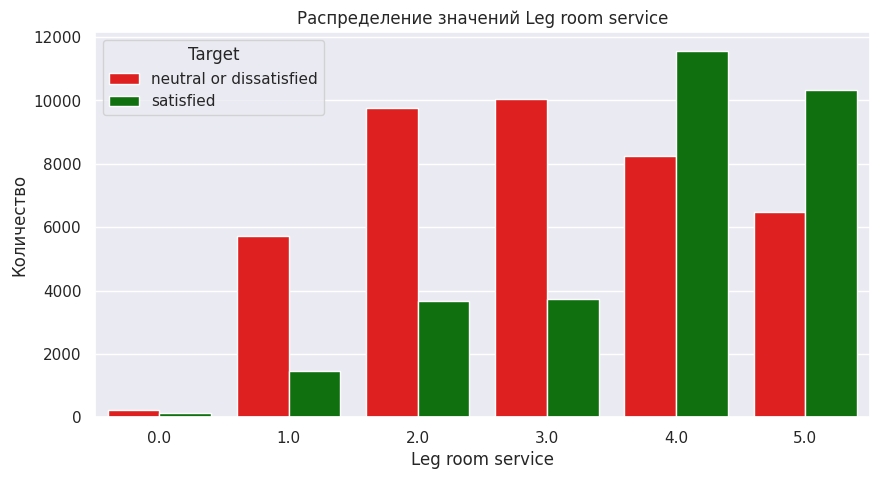

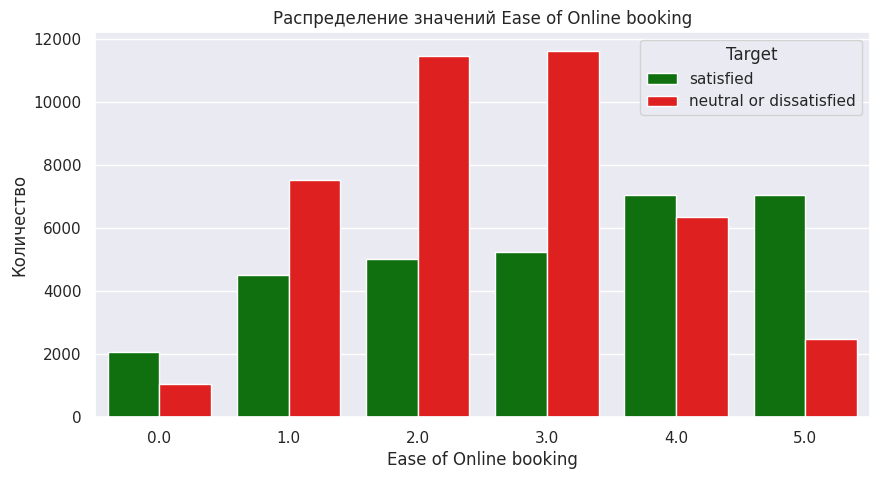

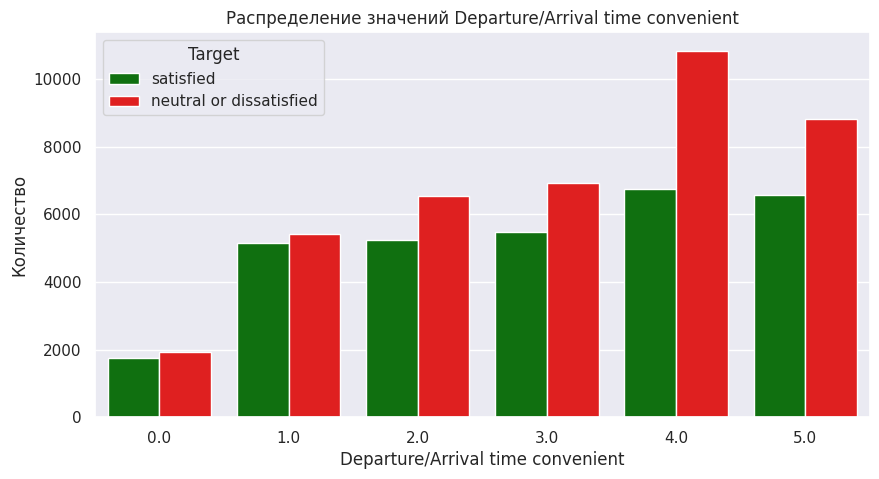

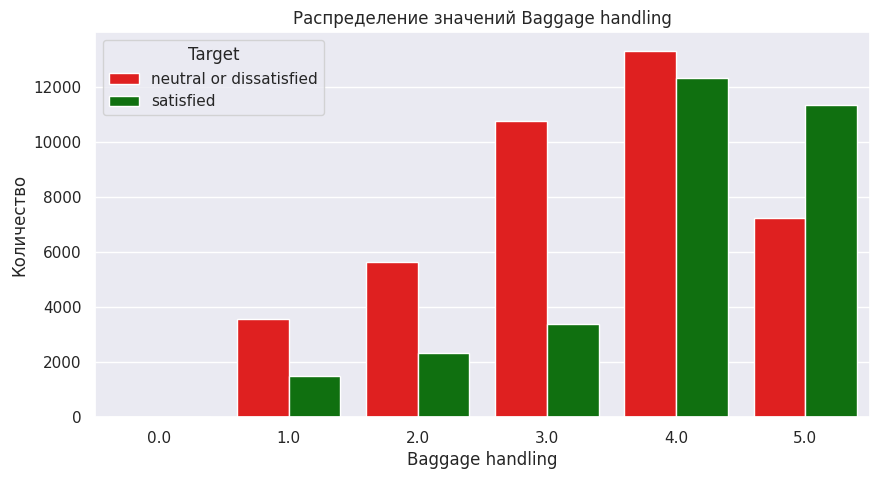

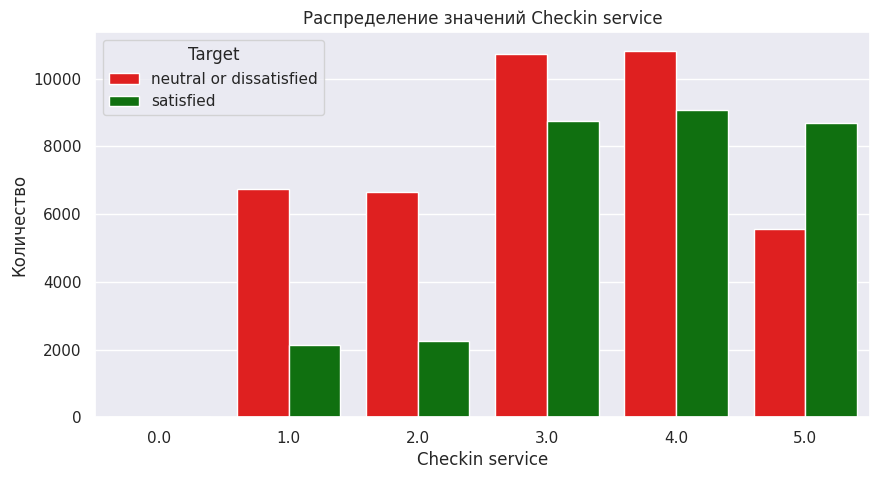

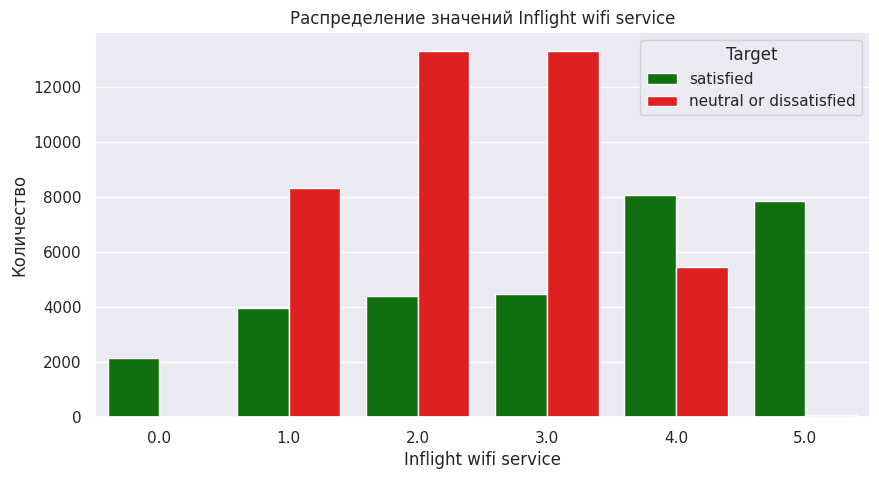

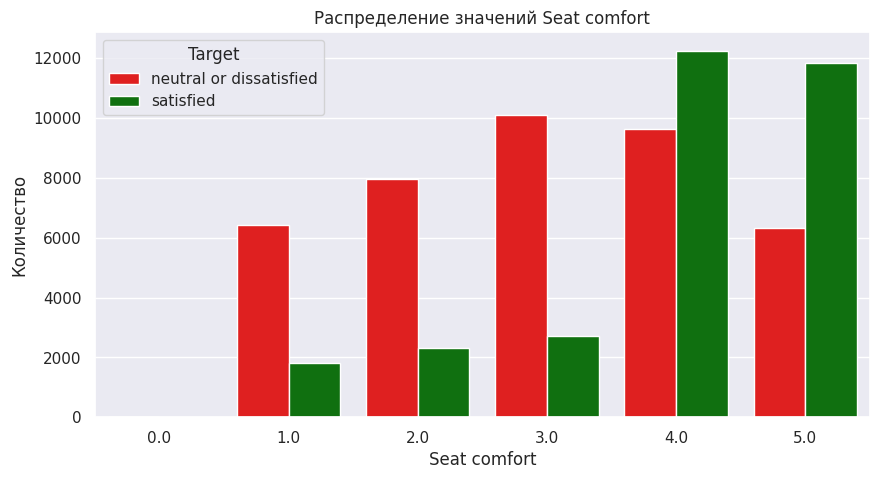

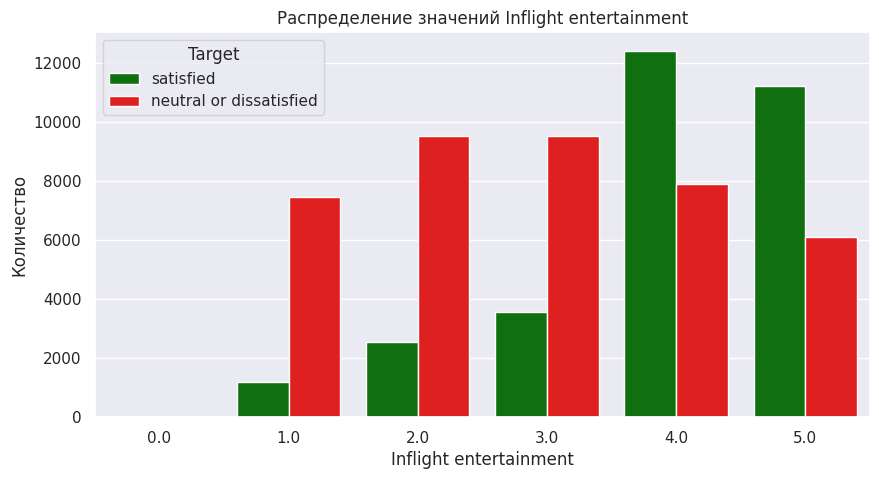

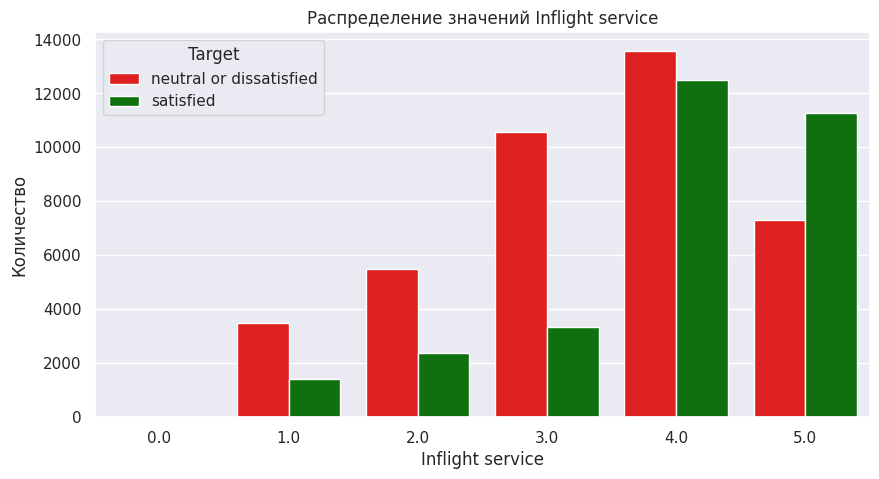

In [251]:
plot_ordinal(ordinal_cols, X_train, y_train)

На графиках красным отмечены неудовлетворенные клиенты, а зеленым удовлетворенные.
1. Графики распределения признаков:
    * gender - можно сказать, что количество межчин и женщин в тренировочных данных одинаковое. Также можно заметить, что почти одинаковое количество мужчин и женщин, которые удовлетворены полетом или нет.
    * Customer Type - количество "loyal Customer" намного больше, чем "disloyal Customer", но и там и там недовольных/нейтральных клиентов больше, чем довольных. Однако, численно недовольных/нейтральных клиентов больше в колонке "disloyal Customer".
    * Type of Travel - людей, планирующие "businiess travel" больше и они больше удовлетворенны полетом, чем другие, что вполне логиично.
    * class - как можно заметить, большего всего удовлетворены полетом люди, которые летели классом "bussiness", остальные в большестве не довольны полетом.
2. Континуальные признаки:
    * Departure Delay in Minutes, Arrival Delay in Minutes- по графикам распределния видно, что данные признаки не влияют на удовлетворенность полета клиентом, практически в равной мере есть как двольные клиенты, так и нет, при равных значений признаков. Также по ящику с усами видно, что есть большое количество "выбросов", которые не попали в удаление.
    * age - как можно заметить, пик недовольных людей приходит на возраст от 20 до 25. Возраст удовлетворенных полетом начинает стремиться вверх после 35. Возможно, это связано с тем, что более взрослые люди, могут позволить себе бизнесс класс. Но после 60 лет удовлетворенность клиентов резко падает. Это, в свою очередь, может быть связано с тем, что перелеты на самолетах не такие комфортные для пожилых людей, как им хотелось бы.
    * Flight Distance - из графика распределения видно, что недовольных клиентов на дистанции <1000 самое большое количество. На ящике с усами видно, что присутствуют выбросы в негативной/нейтральной оценке.
3. Признаки с оценками сервисов клиентами:
    * seat comfort, cleanliness, on-board service, leg room service, baggage handling, inflight service - большинство людей, которые оценили полет положительно, также высоко оценили эти значения.
    * ease of online booking, food and drink, inflight wifi service, online boarding, departure/arrival time convenient, checking service, inflight entertainment, gate location - большинство людей, которые оценили полет положительно, оценили данные значения на 2-4 балла из 5, что не так плохо, как могло бы быть. Самую низкую оценку(2) с большим количеством голосов получила услуга wi-fi во время полета.  

Если делать вывод, то можно сказать, что несмотря на то, что клиенты с положительным опытом полета оценили большинство сервисов на 2-4 балла, они все-равно остались довольны.


In [253]:
def plot_categorical_distributions(categorical_cols, X_train, X_val, df_test):
    '''
    Строит графики распределения категориальных признаков
    для трейновой, валидационной и тестовой выборок.
    '''
    for col in categorical_cols:
        train_data = X_train[col].value_counts(normalize=True) * 100
        val_data = X_val[col].value_counts(normalize=True) * 100
        test_data = df_test[col].value_counts(normalize=True) * 100

        combined_data = pd.DataFrame({
            'Train': train_data,
            'Validation': val_data,
            'Test': test_data
        }).T


        combined_data.plot(kind='bar', figsize=(10, 6), alpha=0.7, width=0.8)

        plt.title(f'Распределение {col}', fontsize=14)
        plt.xlabel('Категории', fontsize=12)
        plt.ylabel('Доля значений (%)', fontsize=12)

        plt.legend(title='Выборка', loc='upper right')
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.show()

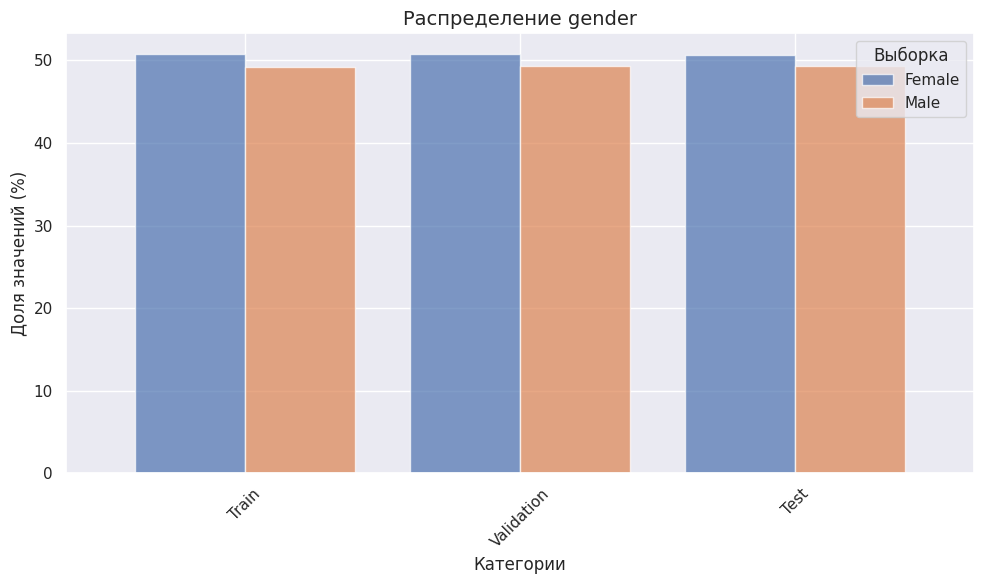

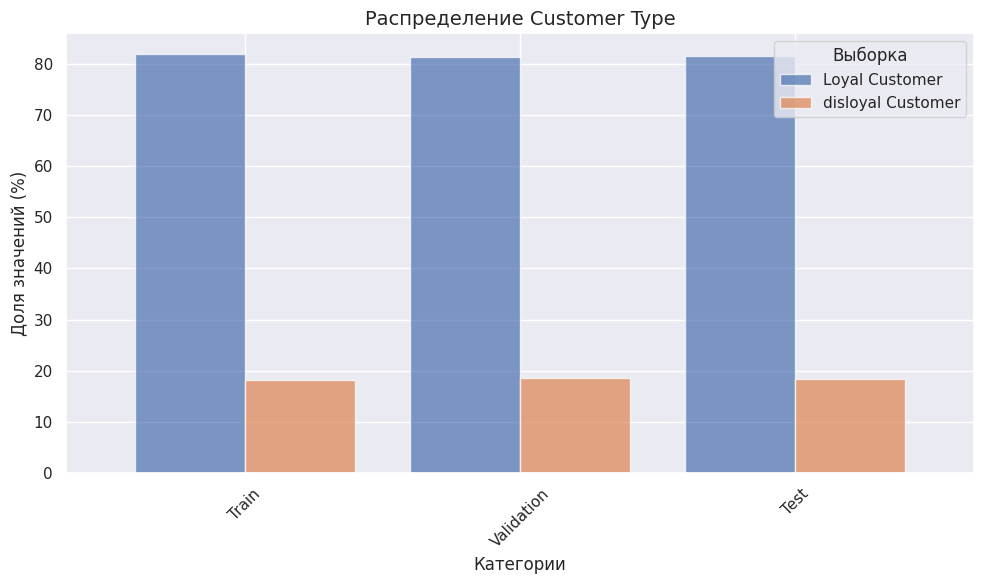

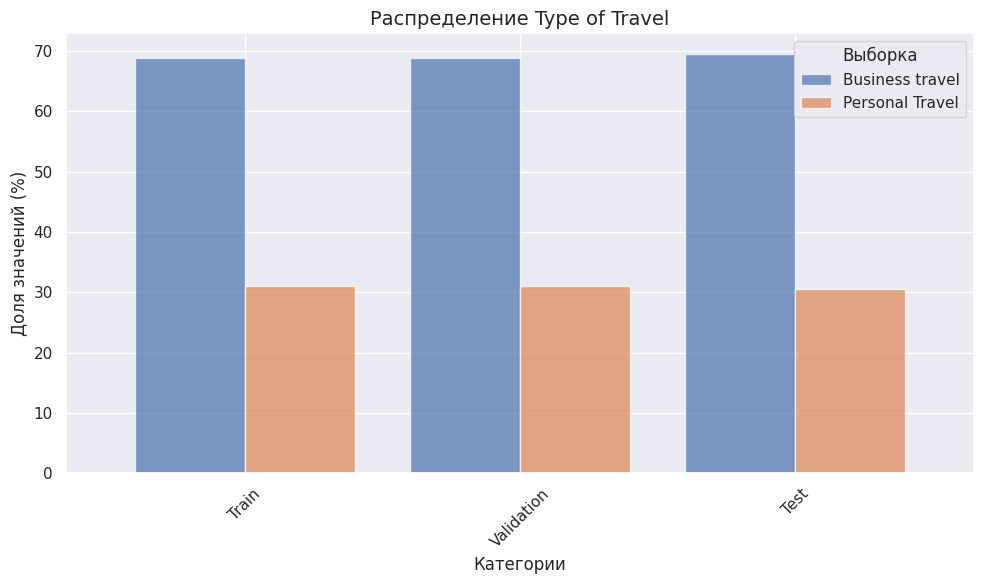

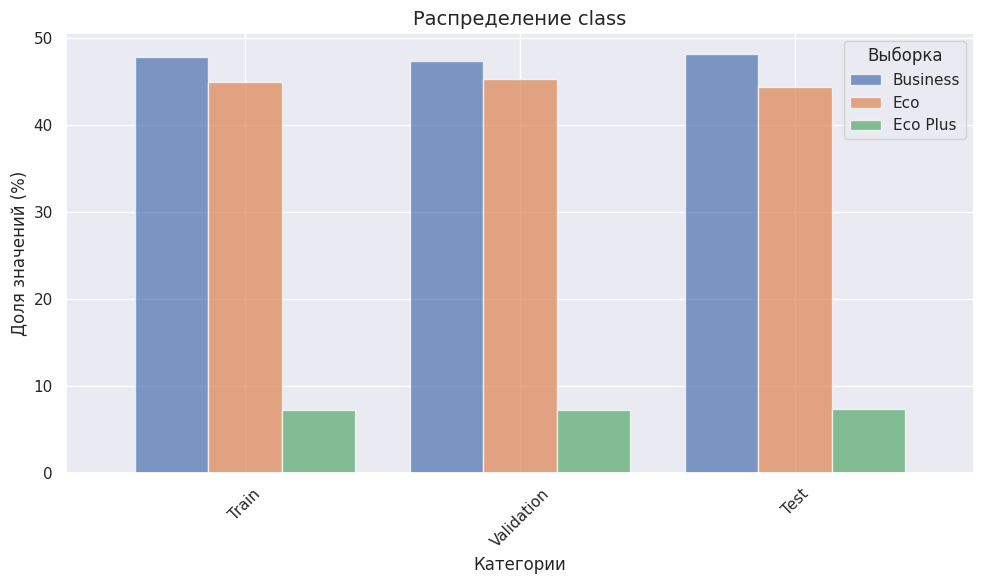

In [254]:
plot_categorical_distributions(categorical_cols, X_train, X_val, df_test)

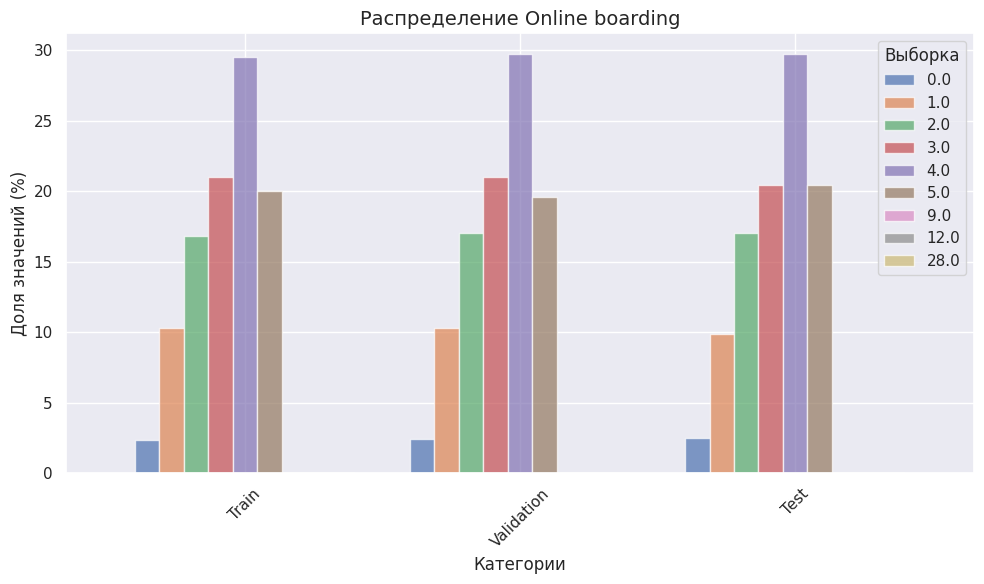

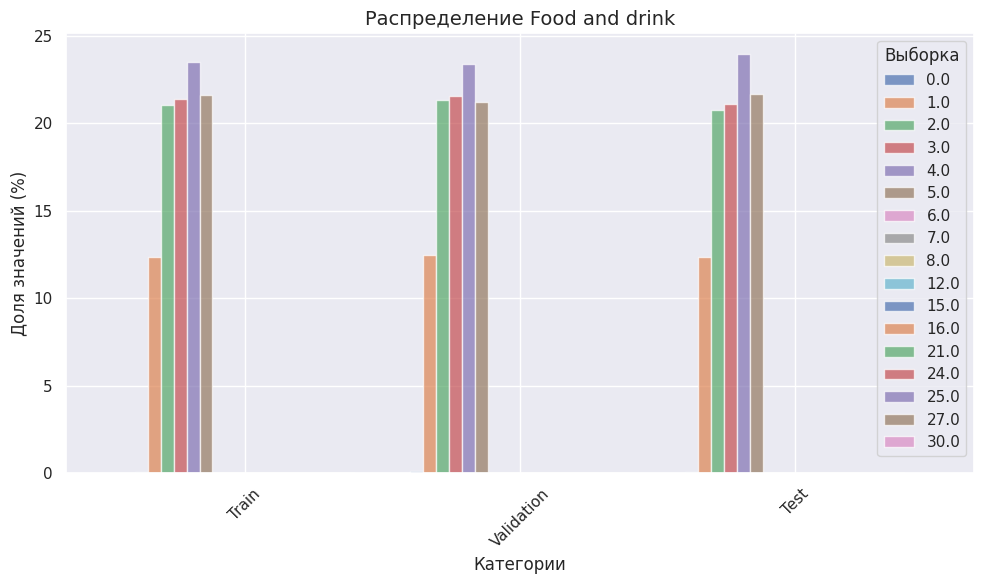

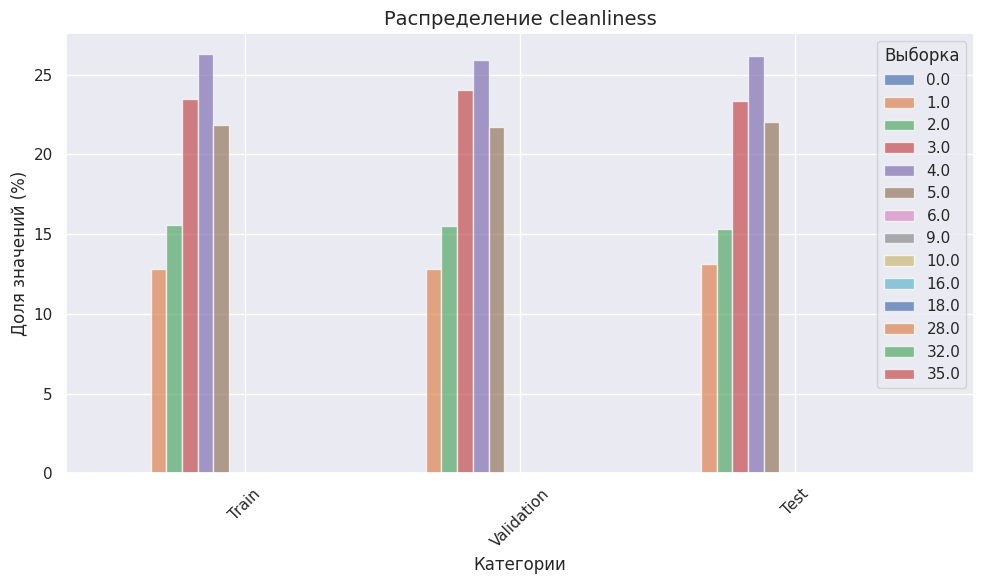

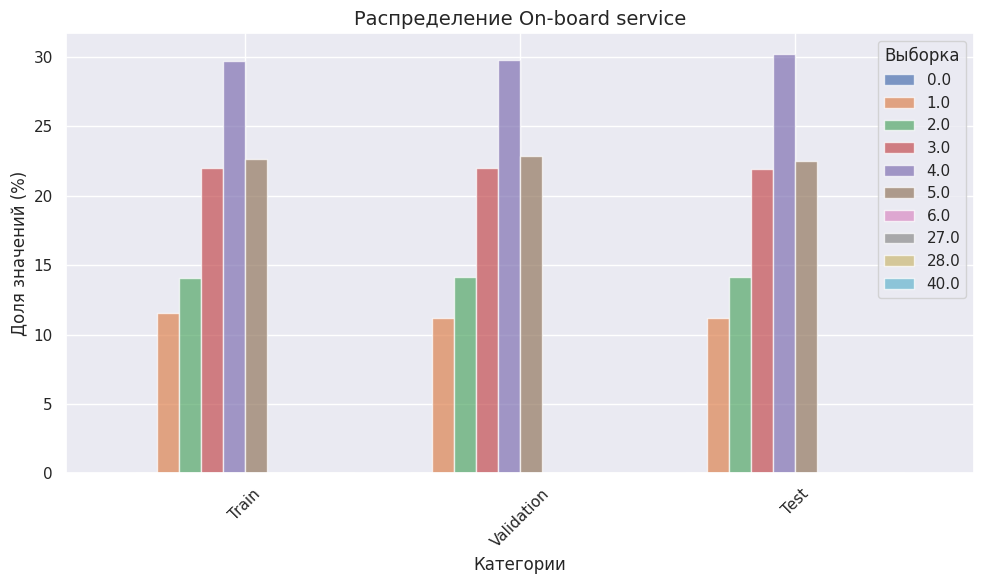

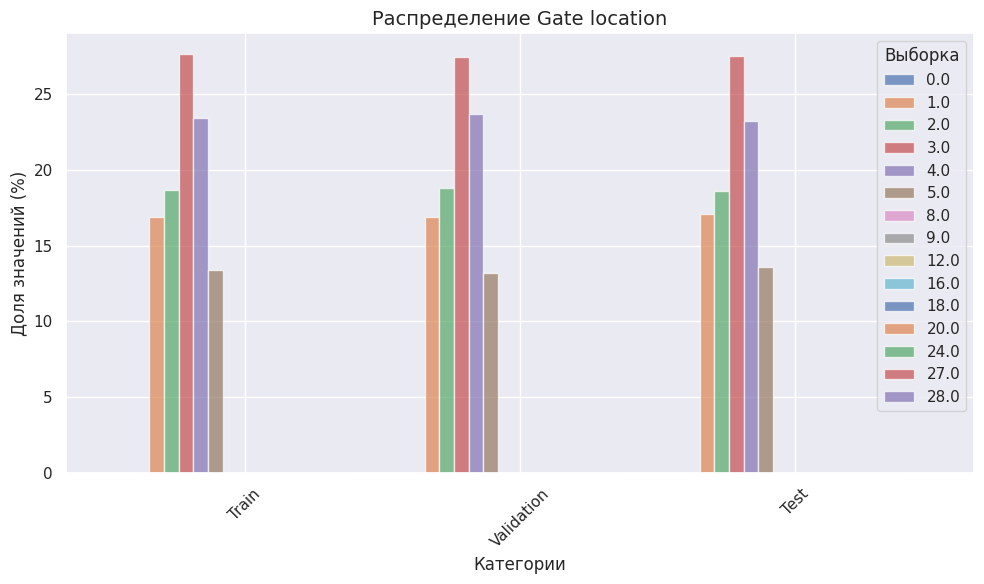

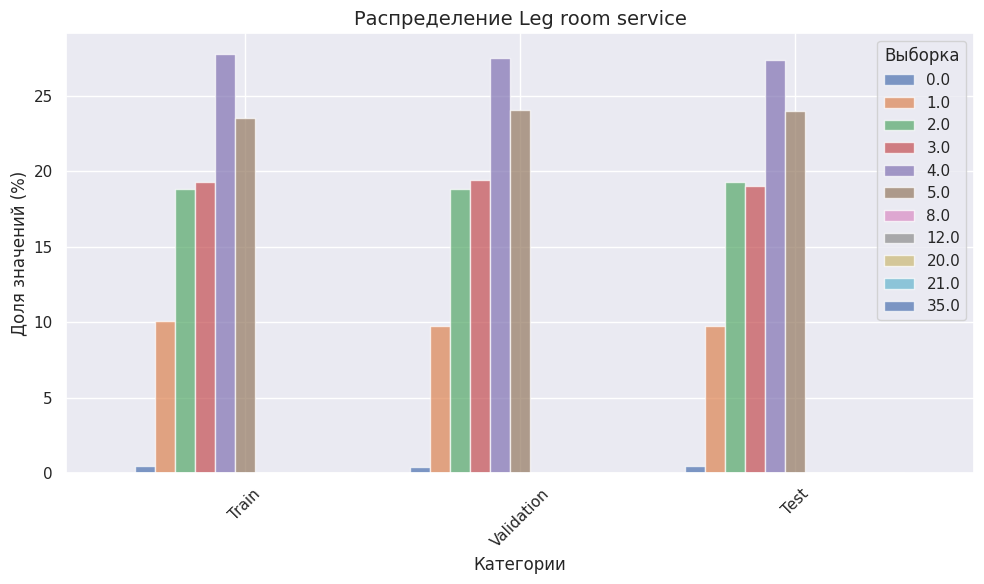

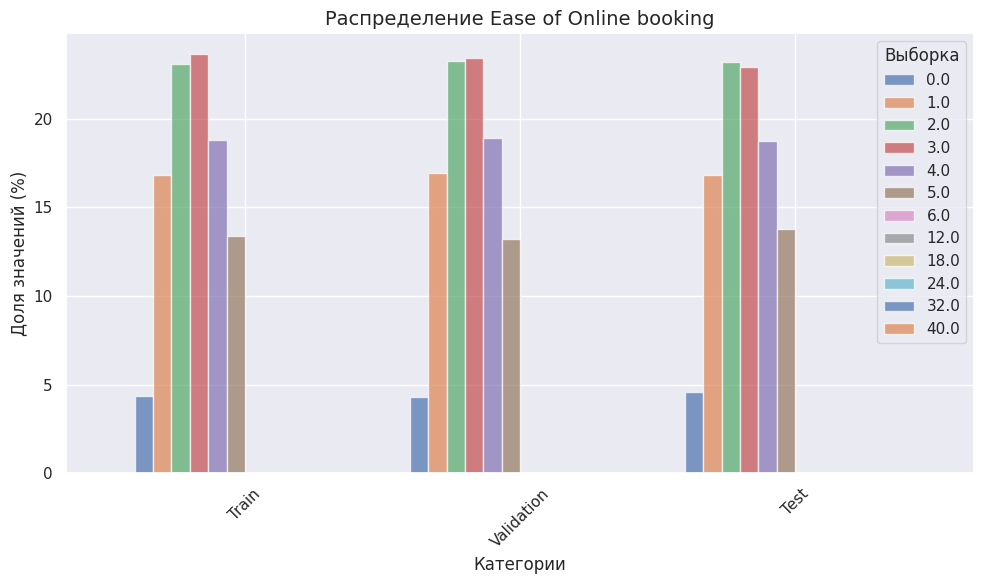

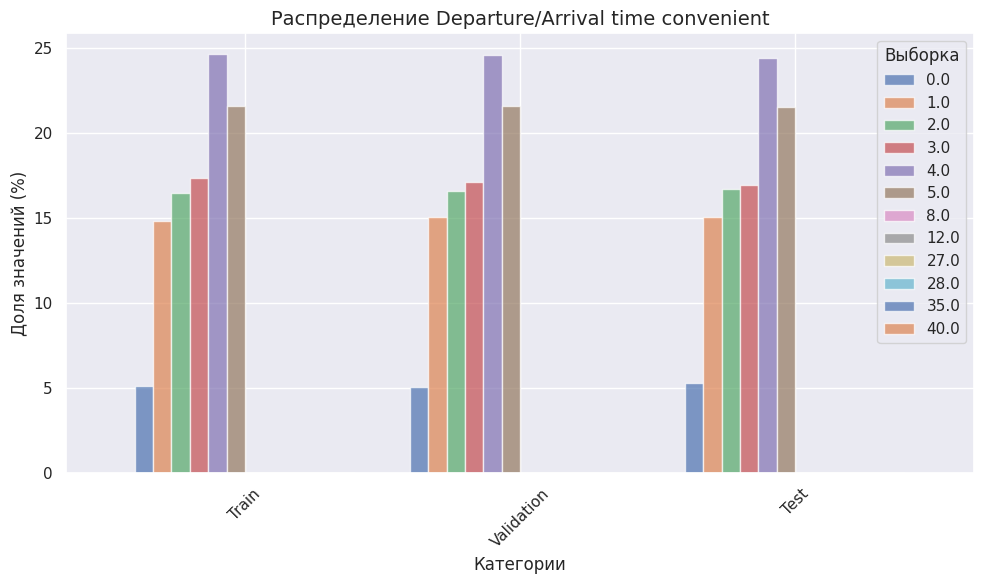

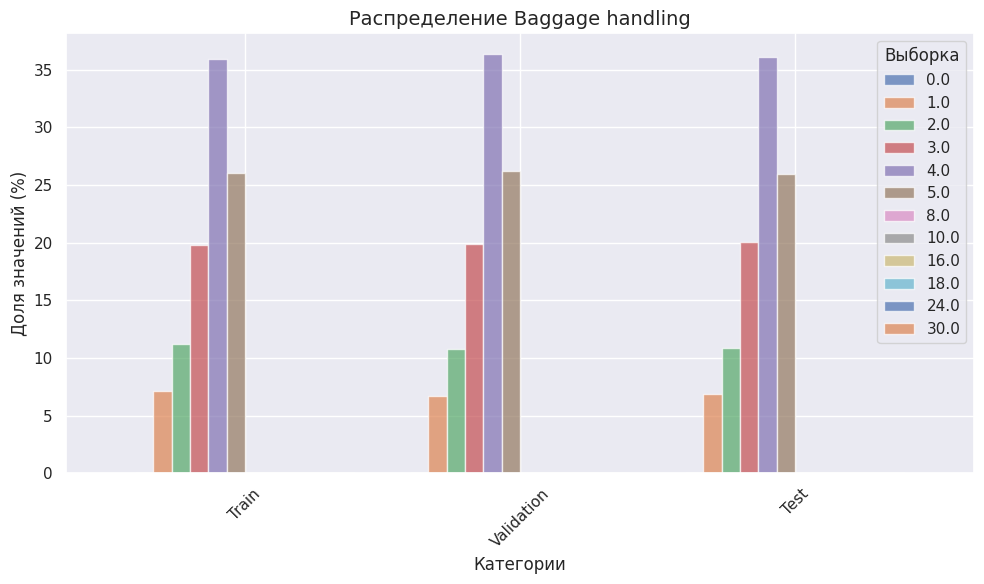

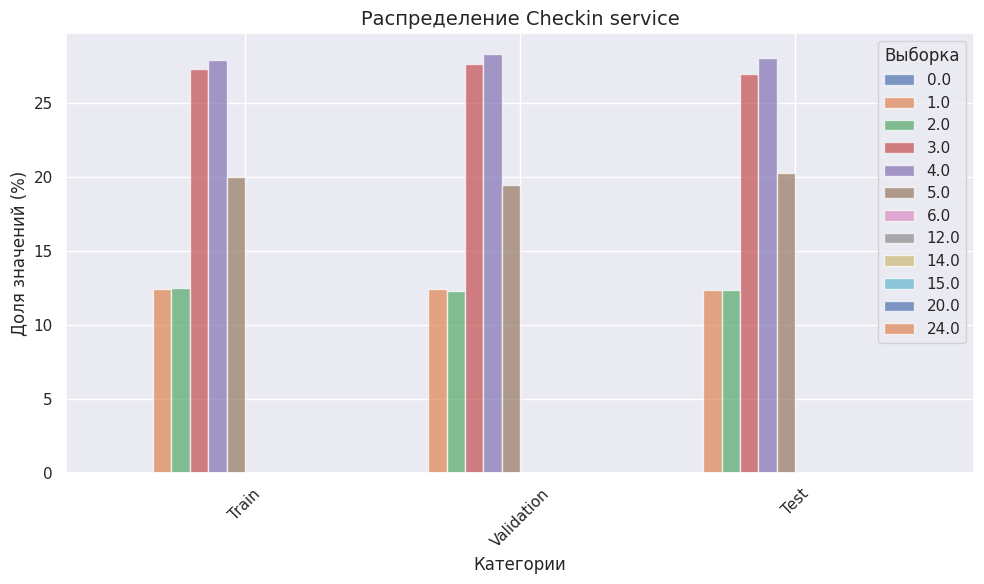

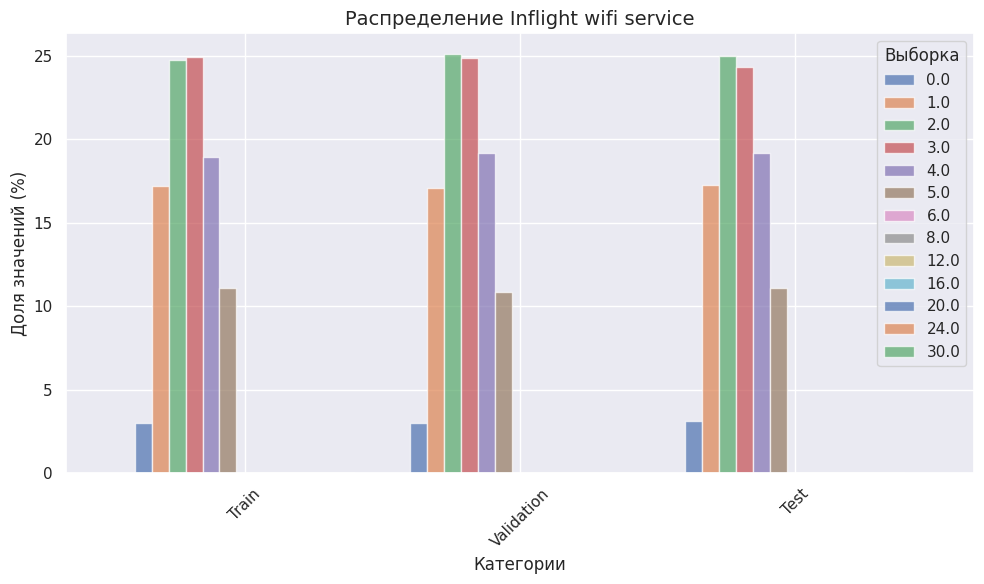

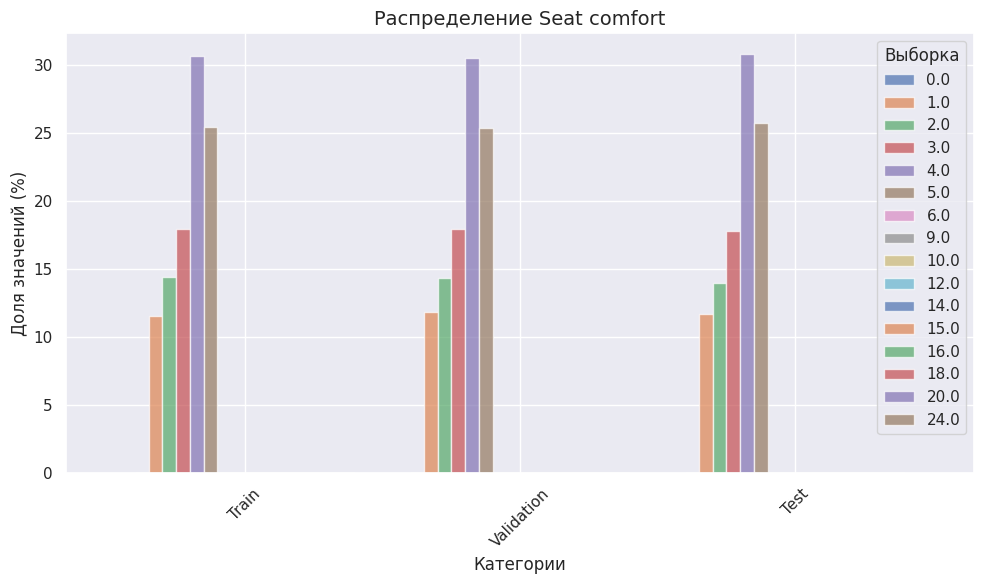

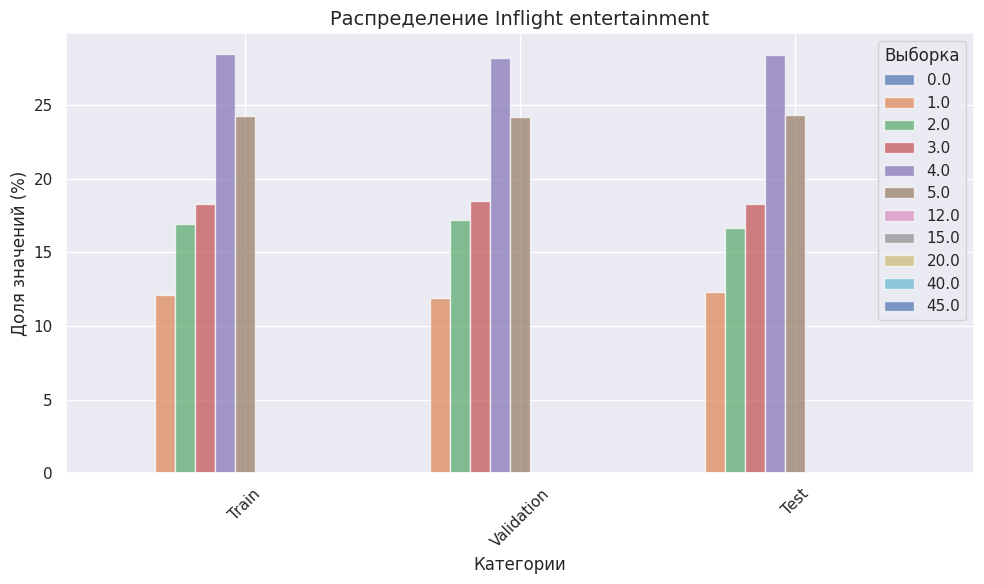

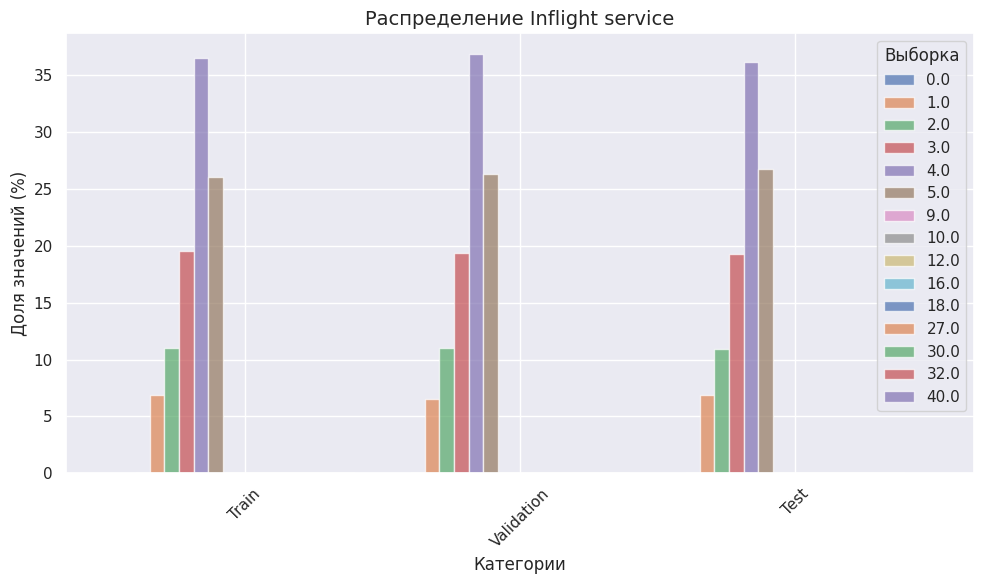

In [255]:
plot_categorical_distributions(ordinal_cols, X_train, X_val, df_test)

Как можно заметить, распределения признаков равномерны при разбиении на трейн, валидацию и тест.

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [256]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

Построение.

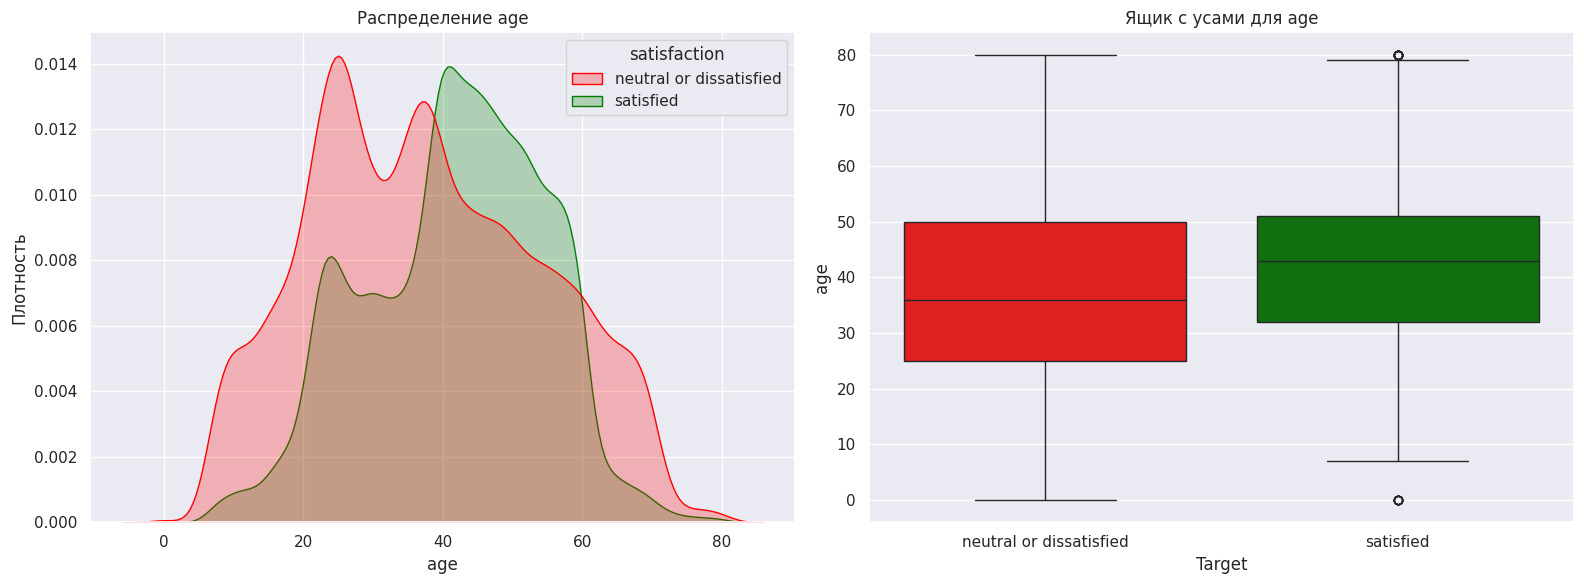

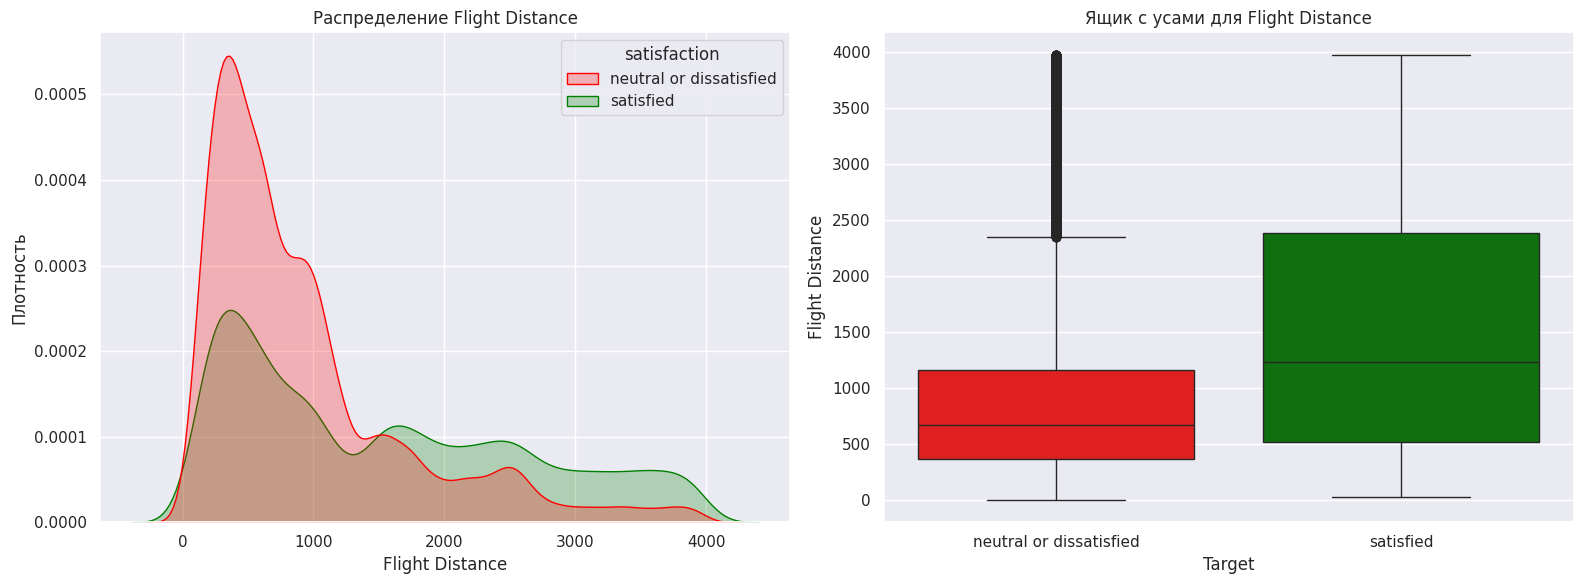

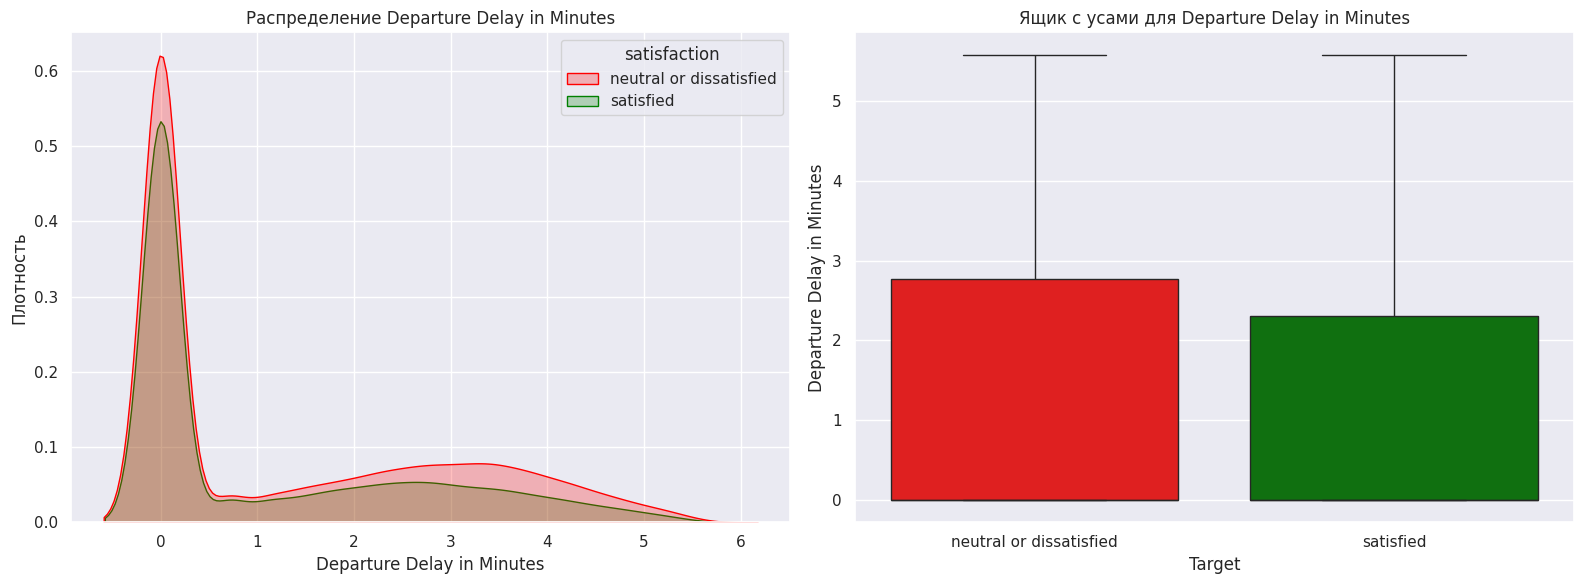

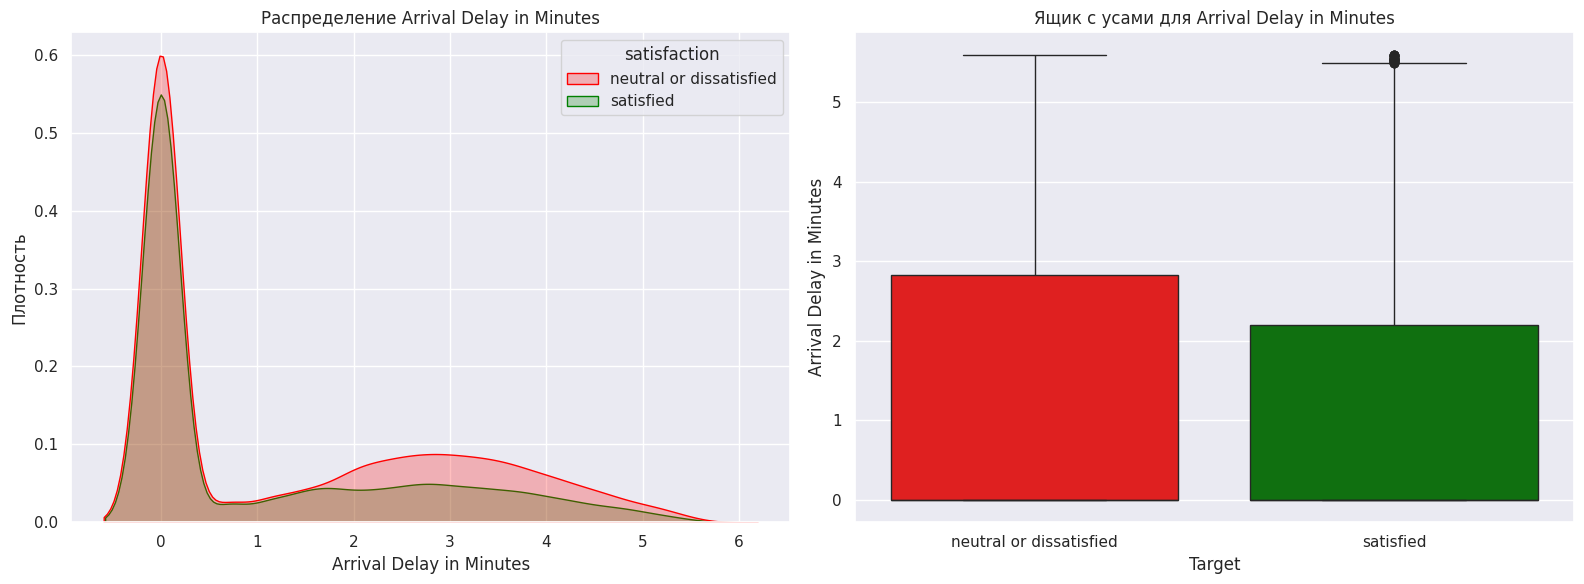

In [257]:
plot_continuous(continuous_cols, X_train, y_train)

Как можно заметить, в ящике с усами теперь нет такого большого количества выбросов, как было до этого. Это связано с тем, что логарифмирование сжимает масштаб значений, поэтому экстремальные значения, которые до этого сильно выделялись, становятся ближе к остальному распределению, что уменьшает их влияние на график.

In [258]:
def plot_pairplot(continuous_cols, X, y):
    '''
    Строит pairplot для континуальных признаков и окрашивает точки в соответствии с классом.
    '''
    y = pd.DataFrame(y)
    y = y.rename(columns={'satisfaction': 'Target'})
    subset_df = pd.concat([X[continuous_cols], y], axis=1)

    subset_df['color'] = subset_df['Target'].map(target_colors)
    palette = list(target_colors.values())

    pairplot = sns.pairplot(
        data=subset_df,
        vars=continuous_cols,
        hue='Target',
        palette=palette,
        diag_kind='kde',
        plot_kws={'alpha': 0.5}
    )

    pairplot.fig.suptitle('Pairplot для континуальных признаков', fontsize=16, y=1.02)

    plt.show()

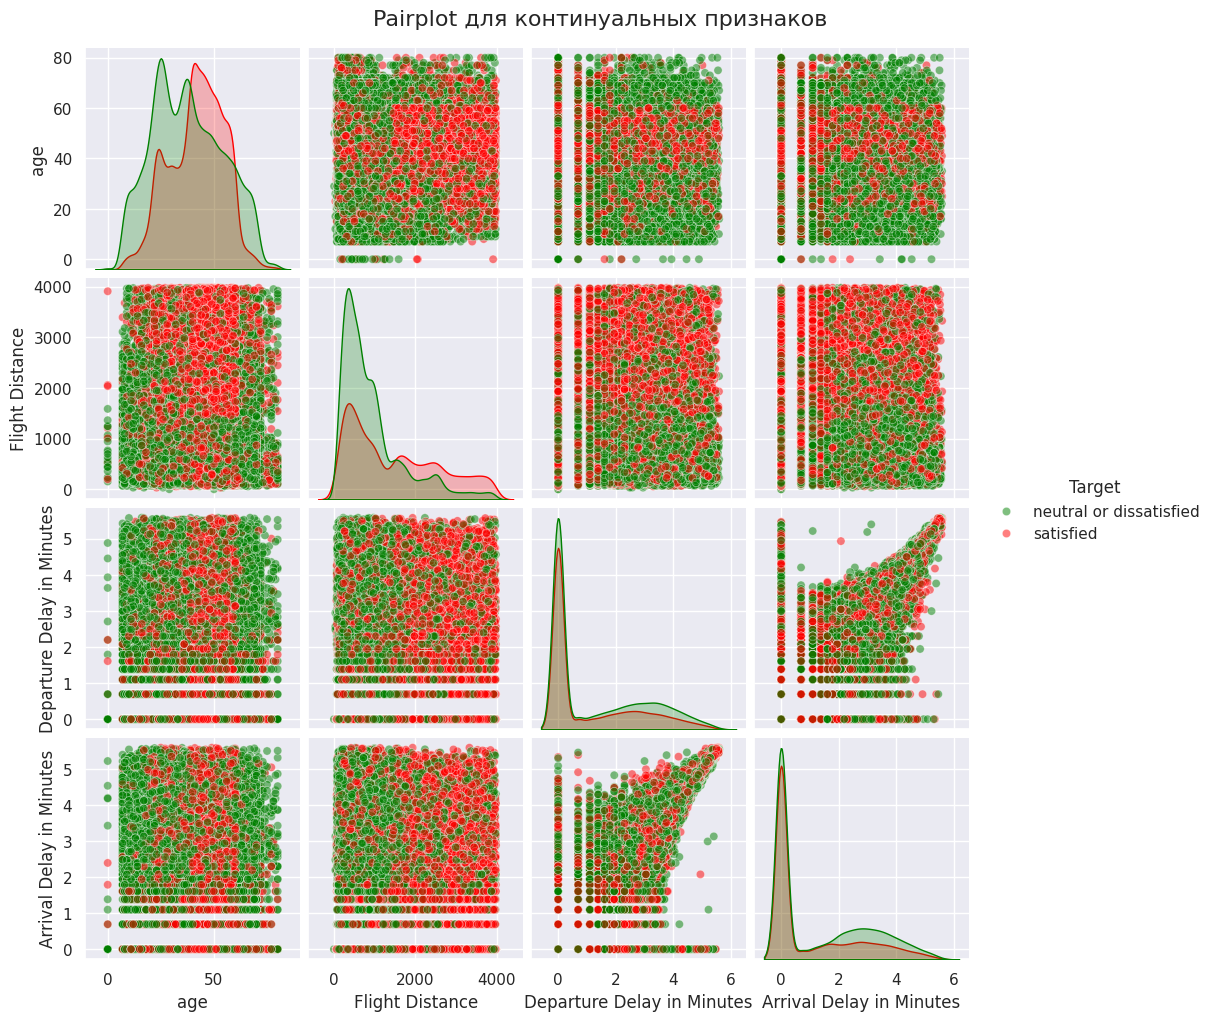

In [259]:
plot_pairplot(continuous_cols, X_train, y_train)

# **Часть 2. Decision Tree**

In [262]:
y_train = (y_train == 'satisfied').astype(int)
y_val = (y_val == 'satisfied').astype(int)

In [263]:
# Кодировка категориальных признаков методом OHE с удалением одного столбца
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True, dtype=int)

In [264]:
assert y_train.shape[0] == X_train.shape[0]

In [265]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train, y_train)

y_pred = model_decision_tree.predict(X_val)
accuracy_model = accuracy_score(y_val, y_pred)

print(f'Accuracy на валидационной выборке: {accuracy_model:.4f}')

Accuracy на валидационной выборке: 0.9125


Значения accuracy находится в диапазоне [0, 1]. По полученному значению можно сказать, что почти все предсказания нашей модели верны.

## **Анализ построенной модели**

In [267]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    model_decision_tree,
    X_train.values, y_train.values,
    X_val.values, y_val.values,
    loss='0-1_loss',
    random_seed=42
)

print(f'Общая ошибка (Error): {error_dt:.4f}')
print(f'Смещение (Bias): {bias_dt:.4f}')
print(f'Дисперсия (Variance): {var_dt:.4f}')

Общая ошибка (Error): 0.0866
Смещение (Bias): 0.0497
Дисперсия (Variance): 0.0704


Общая ошибка показывает, что модель ошибается примерно в 8,6% случаев.\
Смещение равно 0.0497 , что относительно низкое значение. Это указывает на то, что модель способна уловить основные зависимости в данных и не является сильно недообученной.\
Дисперсия равна 0.0704 , что выше, чем смещение. Это указывает на то, что модель имеет тенденцию переобучаться на тренировочных данных.

**Вывод:** Модель показывает приемлемый уровень ошибки (8.6% ), но имеет некоторый риск переобучения из-за высокой дисперсии.

In [268]:
depth = model_decision_tree.get_depth()
leaves = model_decision_tree.get_n_leaves()

print(f'Глубина дерева: {depth}')
print(f'Количество листьев: {leaves}')

Глубина дерева: 31
Количество листьев: 2095


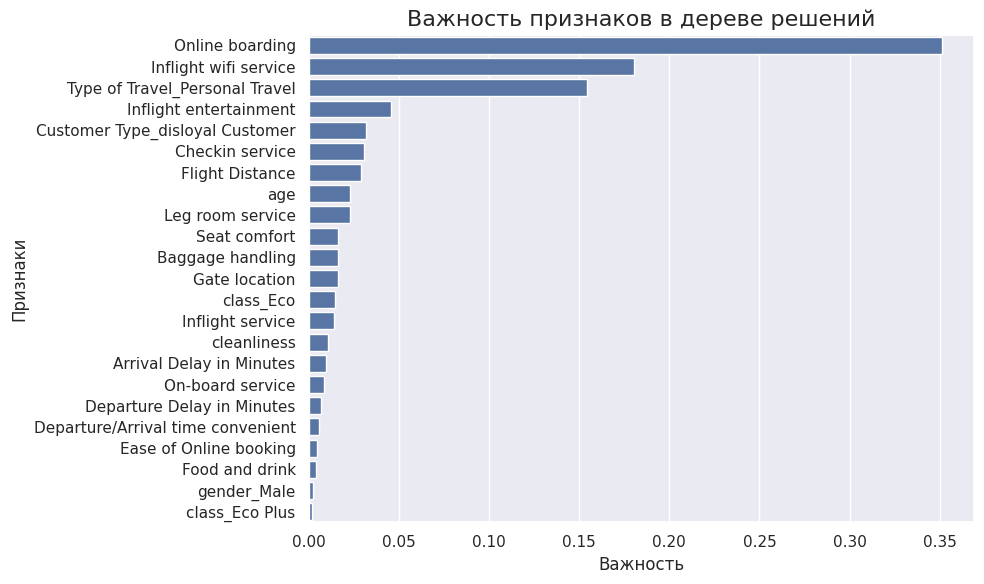

In [278]:
feature_importances = model_decision_tree.feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
importance_df['dummy'] = 'Feature Importance'
sns.barplot(
    data=importance_df,
    x='Importance',
    y='Feature',
    hue='dummy',
    legend=False
)

plt.title('Важность признаков в дереве решений', fontsize=16)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.tight_layout()

plt.show()

In [280]:
# Вывод наиболее информативных признаков
most_important_features = importance_df[importance_df['Importance'] > 0]['Feature'].tolist()
print("Наиболее информативные признаки:")
print(most_important_features[:3])

Наиболее информативные признаки:
['Online boarding', 'Inflight wifi service', 'Type of Travel_Personal Travel']


In [281]:
top_features = most_important_features[:2]

X_train_top = X_train[top_features]
X_val_top = X_val[top_features]

# Обучение нового дерева решений с max_depth=5
model_top = DecisionTreeClassifier(max_depth=5, random_state=42)
model_top.fit(X_train_top, y_train)

y_pred_top = model_top.predict(X_val_top)
accuracy_model_top = accuracy_score(y_val, y_pred_top)

print(f'Accuracy на валидационной выборке: {accuracy_model_top:.4f}')

Accuracy на валидационной выборке: 0.8248


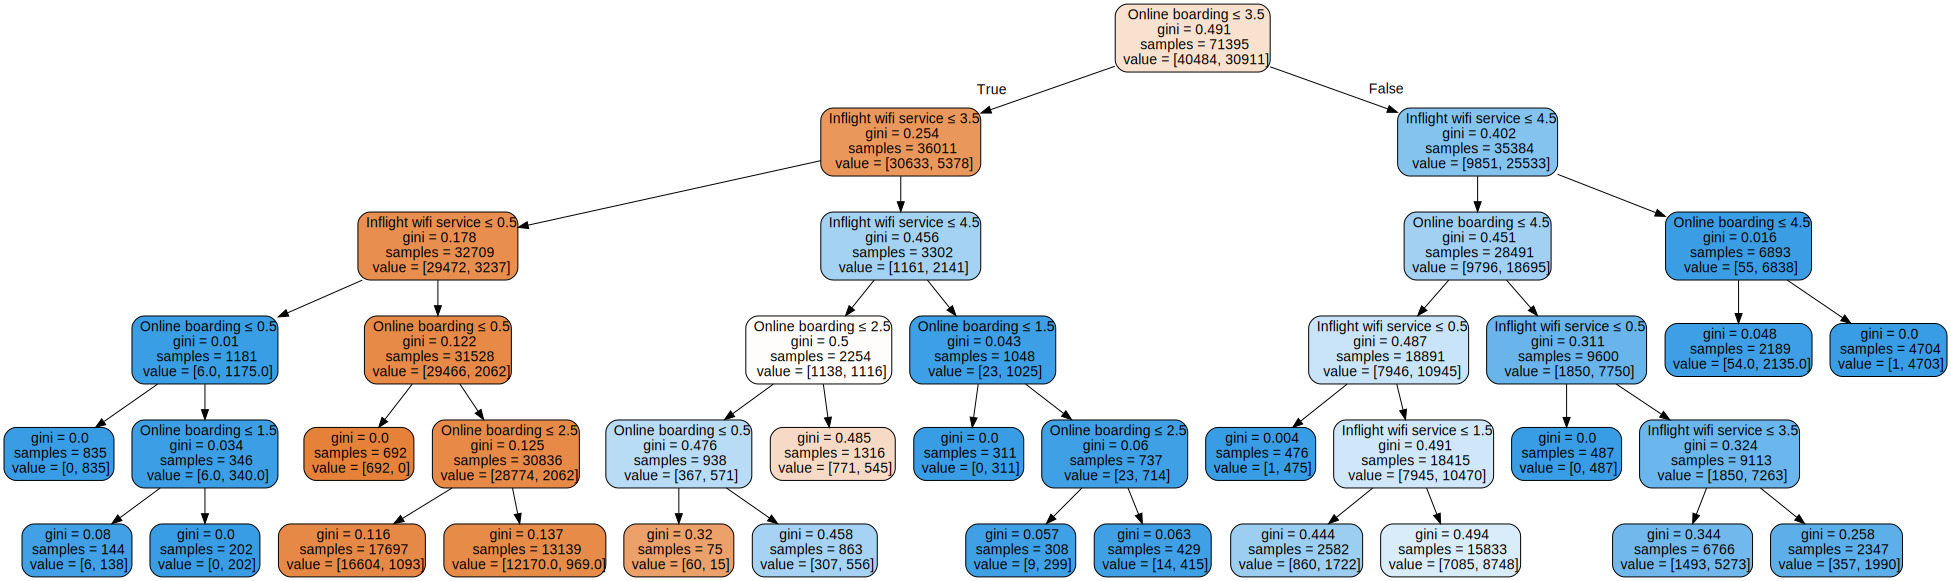

In [286]:
dot_data = export_graphviz(
    model_top,
    feature_names=top_features,
    filled=True,
    rounded=True,
    special_characters=True
)

graph = Source(dot_data)
graph

Предикаты в дереве решений кратны 1/2, потому что алгоритм выбирает оптимальные точки разделения для минимизации функции потерь (вычисляет вероятность классов как долю объектов одного класса в листьях).

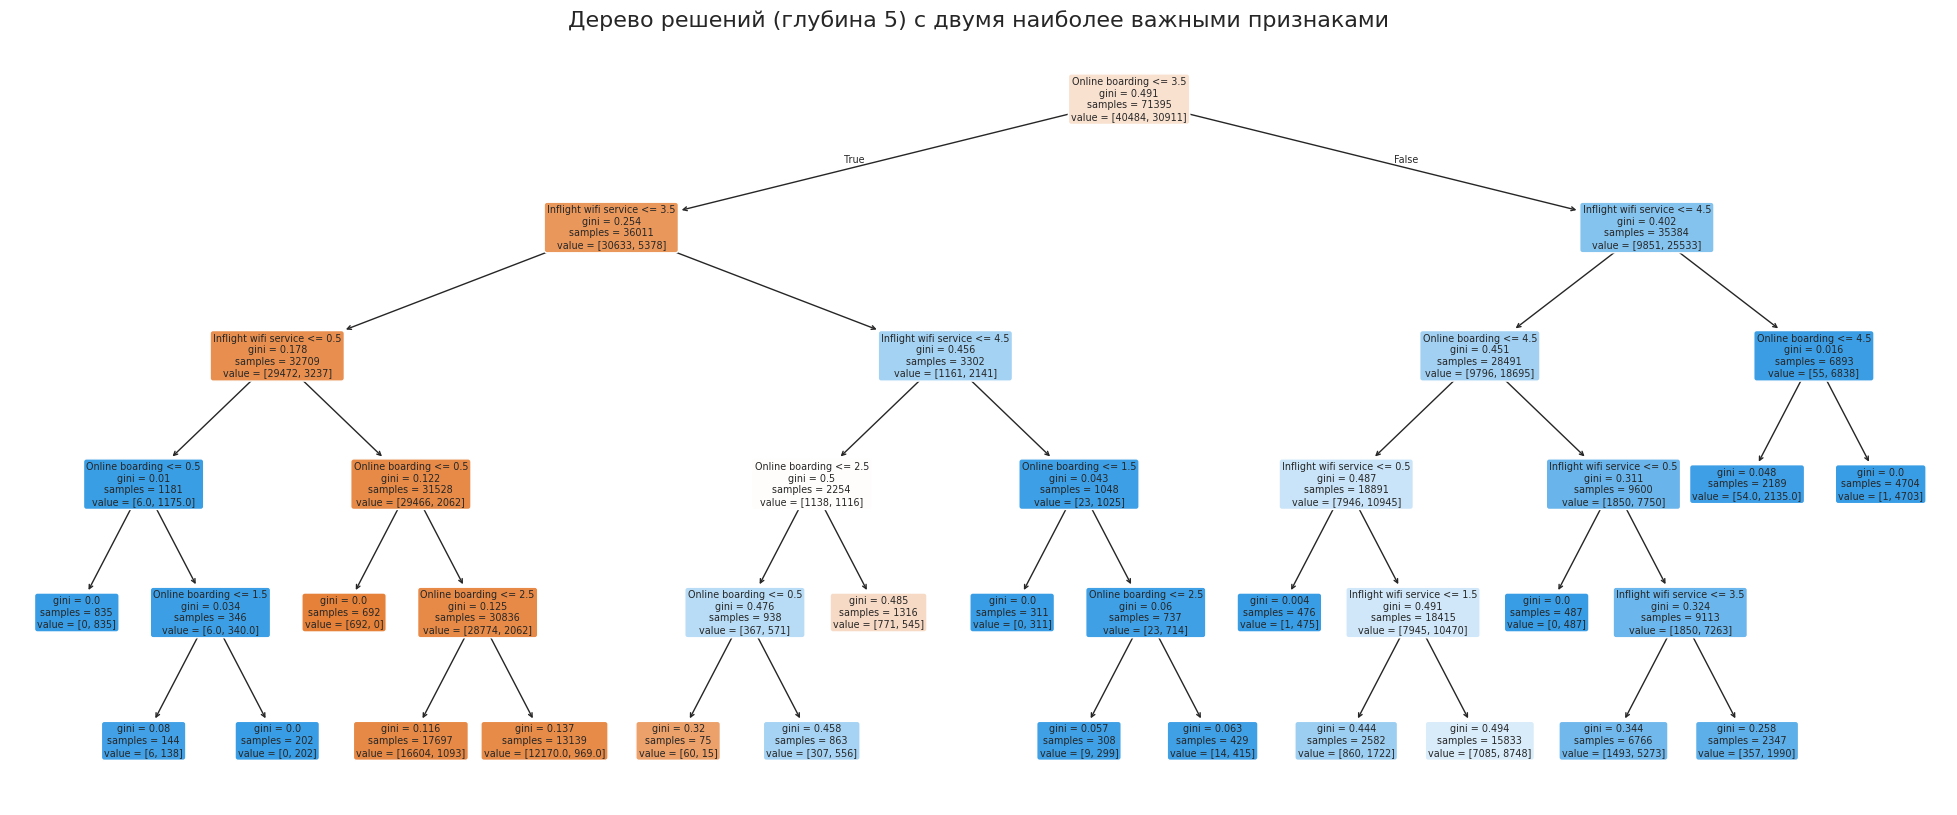

In [290]:
plt.figure(figsize=(25, 10))
plot_tree(
    model_top,
    feature_names=top_features,
    filled=True,
    rounded=True
)
plt.title('Дерево решений (глубина 5) с двумя наиболее важными признаками', fontsize=16)
plt.show()

Дерево асимметрично.\
К плюсам такого дерева относится то, что дерево может отражать реальное распределение данных.Так как один класс встречается гораздо чаще другого, дерево глубже на стороне менее частого класса.\
К минусам же относится то, что асимметричное дерево может указывать на переобучение или какой-то признак может сильно доминировать из-за шума в данных.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


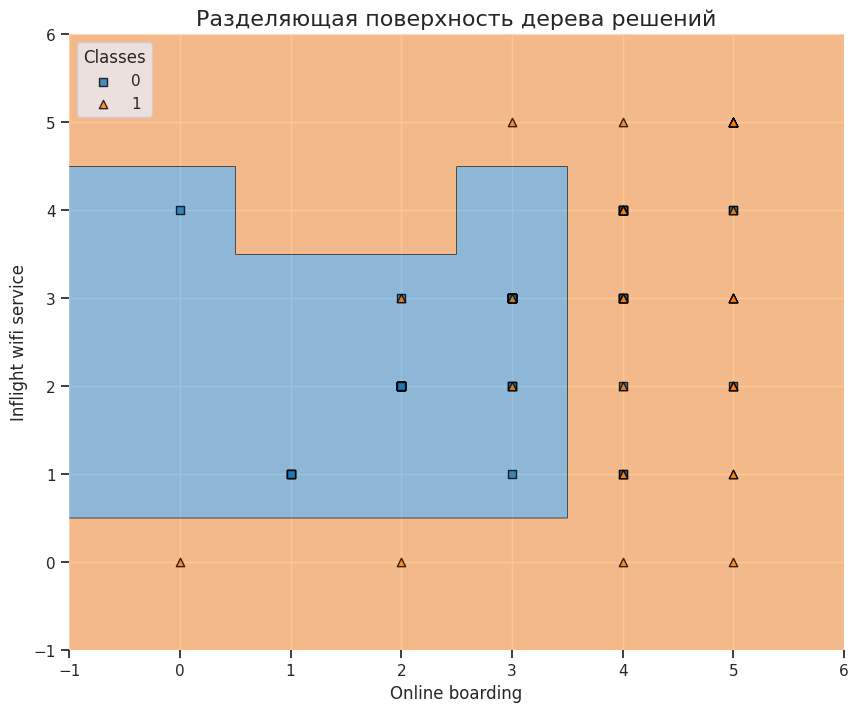

In [295]:
X_train_top_100 = X_train_top.iloc[:100]  # Первые 100 объектов с двумя признаками
y_train_top_100 = y_train.iloc[:100]      # Соответствующие метки

plt.figure(figsize=(10, 8))
plot_decision_regions(
    X_train_top_100.to_numpy(),
    y_train_top_100.to_numpy(),
    clf=model_top,
    legend=2
)

plt.title('Разделяющая поверхность дерева решений', fontsize=16)
plt.xlabel(top_features[0], fontsize=12)
plt.ylabel(top_features[1], fontsize=12)
plt.legend(loc="upper left", title="Classes")
plt.grid(True, linestyle='-')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

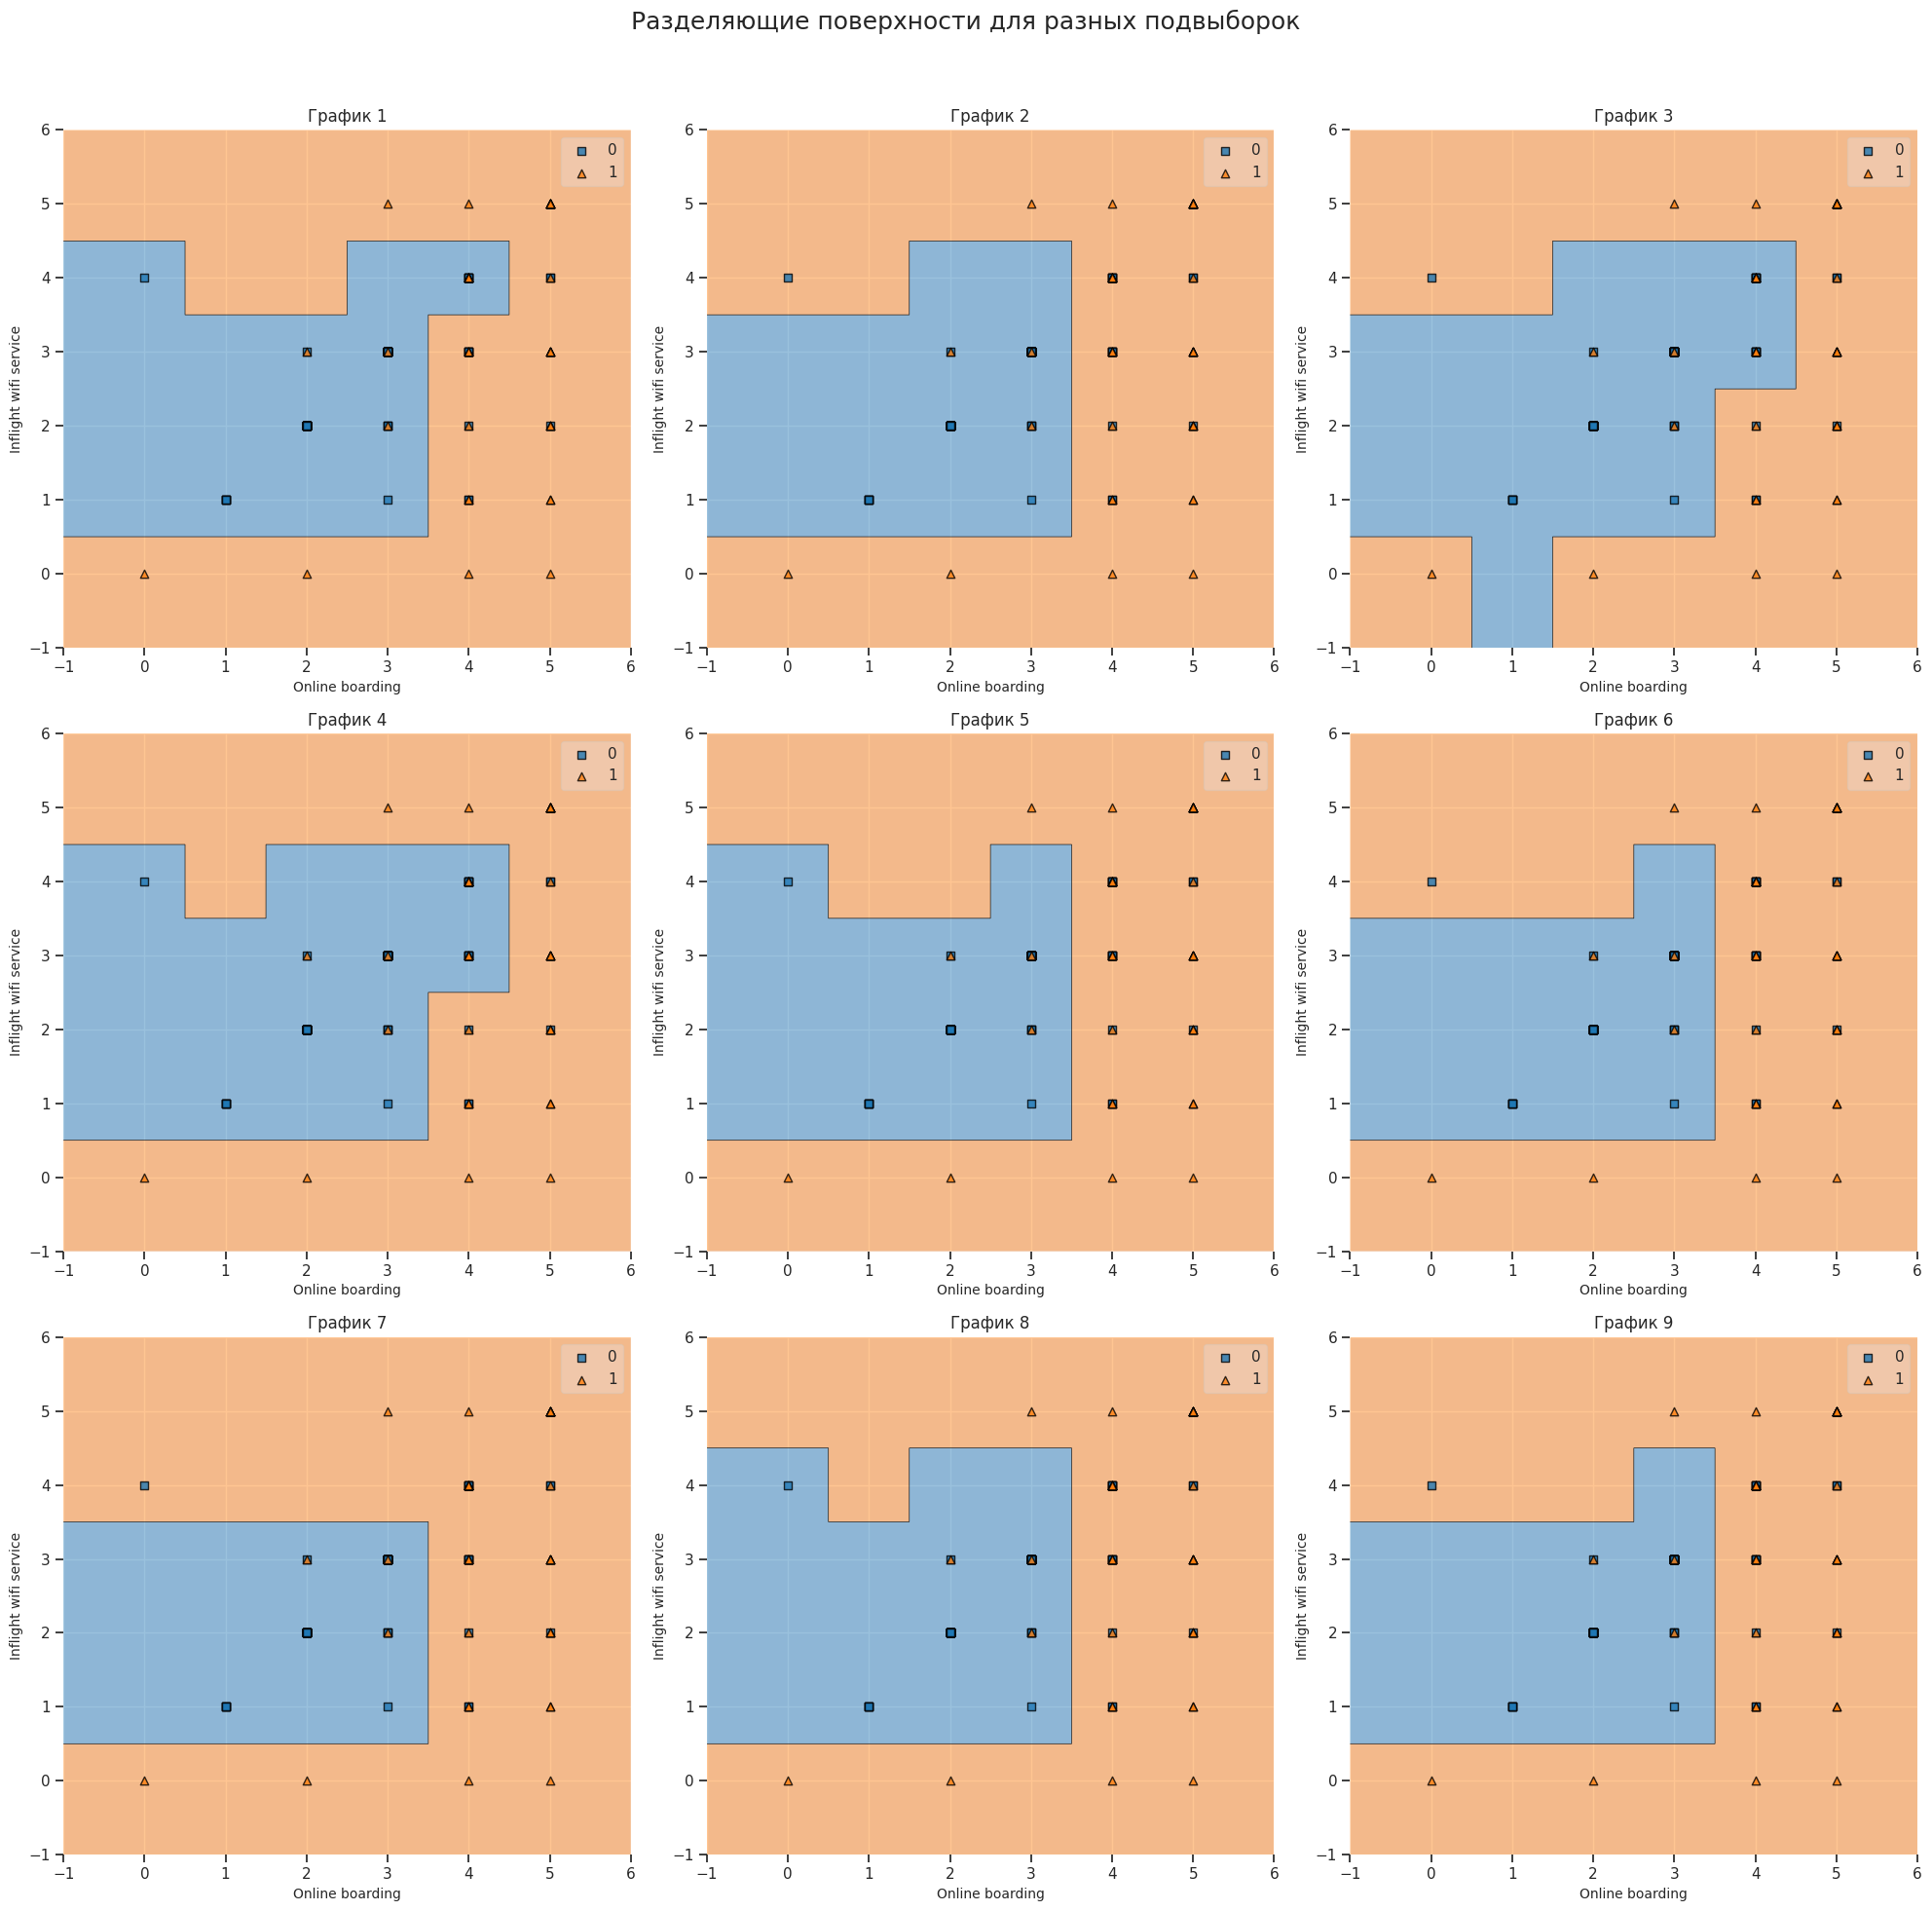

In [314]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(
                                X_train[top_features].index,
                                size=X_train[top_features].shape[0] - 70000,
                                replace=False
                                ) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train[top_features].loc[inds, :], y_train[inds])


        plot_decision_regions(
                            clf=tree_exp,
                            X=np.array(X_train[top_features].iloc[:100, :]),
                            y=np.array(y_train[:100]),
                            ax=ax[row][col],
                            feature_index=[0, 1],
                            filler_feature_values={},
                            filler_feature_ranges={}
                            )

        # Настройка заголовка для каждого подграфика
        ax[row][col].set_title(f'График {row * 3 + col + 1}', fontsize=12)
        ax[row][col].set_xlabel(X_train_example.columns[0], fontsize=10)
        ax[row][col].set_ylabel(X_train_example.columns[1], fontsize=10)

fig.suptitle('Разделяющие поверхности для разных подвыборок', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [316]:
%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 4.6 s, sys: 3.21 ms, total: 4.6 s
Wall time: 4.85 s


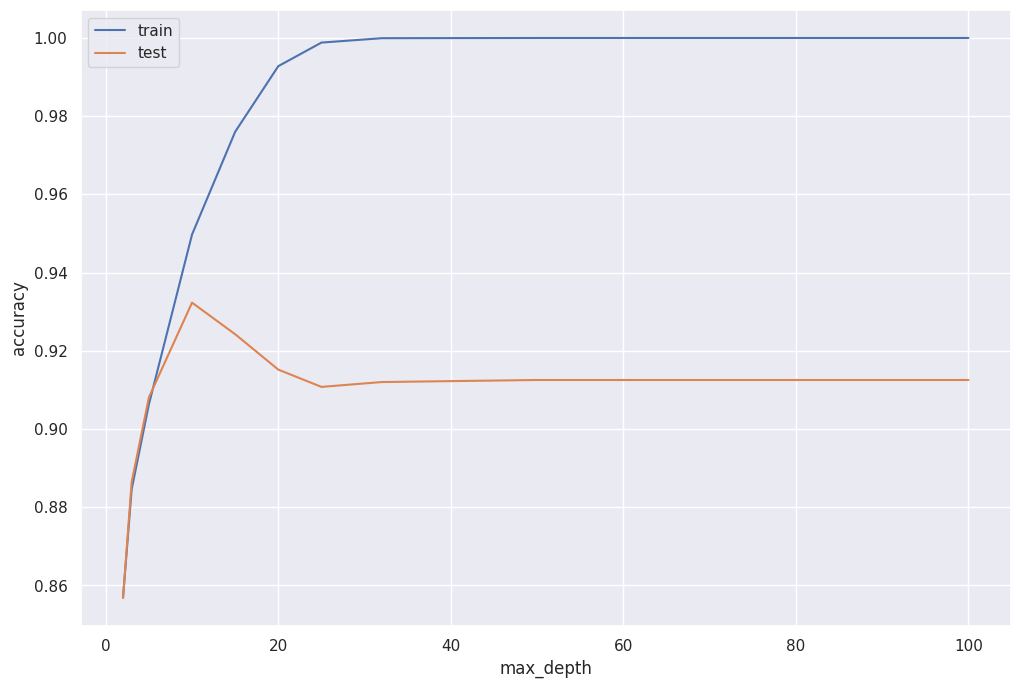

In [317]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

In [319]:
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
}

grid_search = GridSearchCV(
    estimator=model_decision_tree,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"Качество на кросс-валидации (accuracy): {best_score:.4f}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 20}
Качество на кросс-валидации (accuracy): 0.9496


In [320]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)

print(f'Качество на валидационной выборке (accuracy): {val_accuracy:.4f}')

Качество на валидационной выборке (accuracy): 0.9474


Удалось улучшить качество с 0.91 до 0.95

In [321]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# **Часть 3. Random Forest**

In [322]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

y_val_pred = random_forest.predict(X_val)

print(f'Accuracy на валидационной выборке (случайный лес): {accuracy_score(y_val, y_val_pred):.4f}')

Accuracy на валидационной выборке (случайный лес): 0.9615


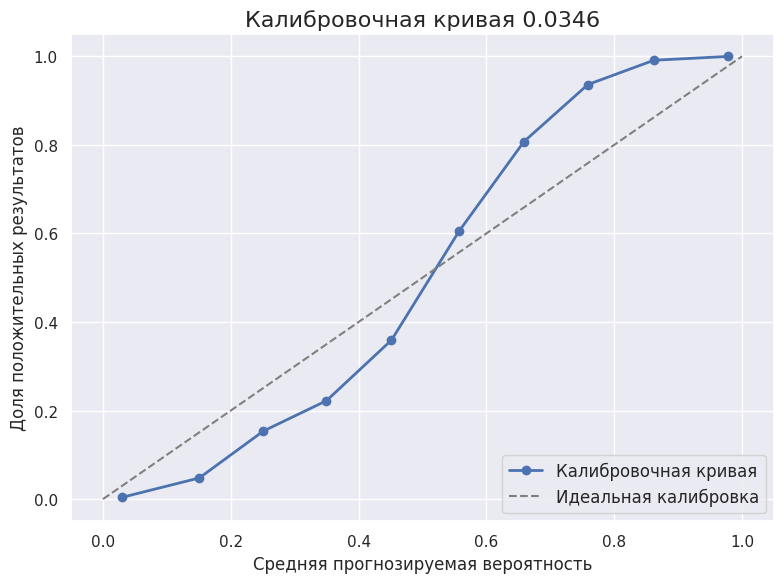

In [327]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

y_prob = random_forest.predict_proba(X_val)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_val, y_prob, n_bins=10, strategy='uniform'
)
brier_score = brier_score_loss(y_val, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2, label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Идеальная калибровка')

plt.title(f'Калибровочная кривая {brier_score:.4f}', fontsize=16)
plt.xlabel('Средняя прогнозируемая вероятность', fontsize=12)
plt.ylabel('Доля положительных результатов', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра



Деревья принимают решения о вероятности, опираясь на соотношение объектов в листе, в который попал новый объект. Это приводит к неточности предсказаний, особенно в условиях значительного дисбаланса классов.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


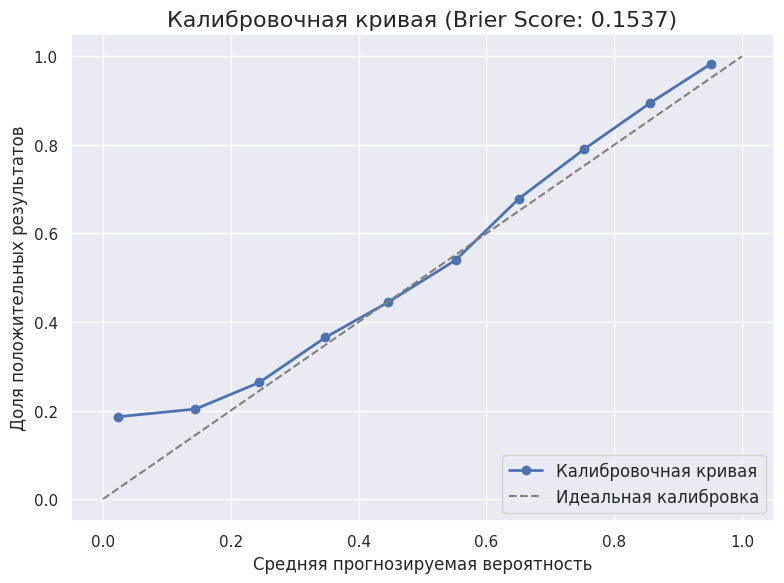

In [328]:
log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
log_reg.fit(X_train, y_train)
y_prob_log_reg = log_reg.predict_proba(X_val)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_val, y_prob_log_reg, n_bins=10, strategy='uniform'
)
brier_score = brier_score_loss(y_val, y_prob_log_reg)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', linewidth=2, label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Идеальная калибровка')
plt.title(f'Калибровочная кривая (Brier Score: {brier_score:.4f})', fontsize=16)
plt.xlabel('Средняя прогнозируемая вероятность', fontsize=12)
plt.ylabel('Доля положительных результатов', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности



Логистическая регрессия считается корректно предсказывающей вероятности, потому что ее выходная функция ограничена в интервале от 0 до 1 и ее обучение основано на максимизации правдоподобия.

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


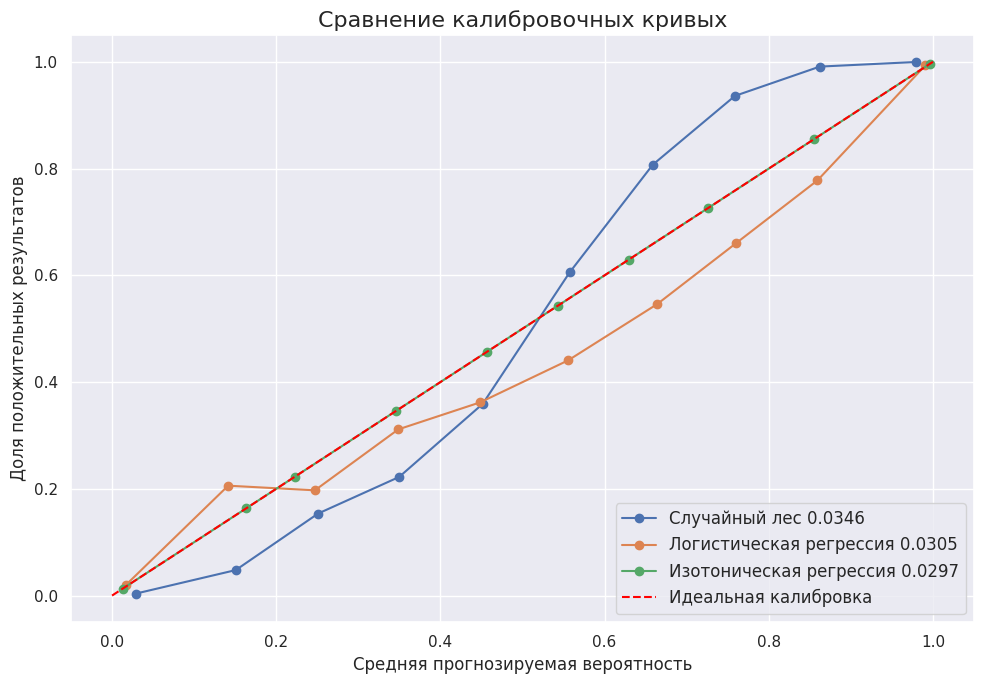

In [338]:
from sklearn.calibration import CalibratedClassifierCV

# Калибровка с помощью логистической регрессии
calibrated_lr = CalibratedClassifierCV(random_forest, method='sigmoid', cv='prefit')
calibrated_lr.fit(X_val, y_val)
y_prob_calibrated_lr = calibrated_lr.predict_proba(X_val)[:, 1]

# Калибровка с помощью изотонической регрессии
calibrated_iso = CalibratedClassifierCV(random_forest, method='isotonic', cv='prefit')
calibrated_iso.fit(X_val, y_val)
y_prob_calibrated_iso = calibrated_iso.predict_proba(X_val)[:, 1]

fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_val, y_prob, n_bins=10)
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_val, y_prob_calibrated_lr, n_bins=10)
fraction_of_positives_iso, mean_predicted_value_iso = calibration_curve(y_val, y_prob_calibrated_iso, n_bins=10)

brier_score_rf = brier_score_loss(y_val, y_prob)
brier_score_lr = brier_score_loss(y_val, y_prob_calibrated_lr)
brier_score_iso = brier_score_loss(y_val, y_prob_calibrated_iso)

plt.figure(figsize=(10, 7))
plt.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label=f'Случайный лес {brier_score_rf:.4f}')
plt.plot(mean_predicted_value_lr, fraction_of_positives_lr, marker='o', label=f'Логистическая регрессия {brier_score_lr:.4f}')
plt.plot(mean_predicted_value_iso, fraction_of_positives_iso, marker='o', label=f'Изотоническая регрессия {brier_score_iso:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Идеальная калибровка')
plt.title('Сравнение калибровочных кривых', fontsize=16)
plt.xlabel('Средняя прогнозируемая вероятность', fontsize=12)
plt.ylabel('Доля положительных результатов', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Другие возвожные подходы к калибровке вероятностей (со ссылками на источники)


1. Temperature Scaling — это метод, основанный на идеях Platt Scaling, но адаптированный для нейронных сетей.
Идея заключается в добавлении одного параметра T (temperature), который масштабирует логиты (logits) перед применением softmax. Затем модель обучается минимизировать кросс-энтропию с этим параметром T.
**Источник** https://arxiv.org/abs/1706.04599?spm=2b75ac3d.2ef5001f.0.0.3d4dc9212cHb3q&file=1706.04599
2. Histogram Binning разбивает предсказанные вероятности на фиксированное количество бинов (например, 10). Для каждого бина вычисляется средняя предсказанная вероятность и доля положительных примеров среди объектов, попавших в этот бин.Эти значения используются для корректировки вероятностей.
**Источник** https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf?spm=2b75ac3d.2ef5001f.0.0.3d4dc9212cHb3q&file=calibration.icml05.crc.rev3.pdf


In [341]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train[:1000], y_train[:1000])

error_rf, bias_rf, var_rf = bias_variance_decomp(
    random_forest,
    X_train.values[:1000], y_train.values[:1000],
    X_val.values[:1000], y_val.values[:1000],
    loss='0-1_loss',
    random_seed=42
)

print(f'Случайный лес:')
print(f'Общая ошибка (Error): {error_rf:.4f}')
print(f'Смещение (Bias): {bias_rf:.4f}')
print(f'Разброс (Variance): {var_rf:.4f}')

Случайный лес:
Общая ошибка (Error): 0.0783
Смещение (Bias): 0.0710
Разброс (Variance): 0.0246


In [342]:
# Сравнение с деревом решений
if 'bias_dt' in locals() and 'var_dt' in locals():
    print('\nСравнение с деревом решений:')
    print(f'Смещение (дерево решений): {bias_dt:.4f} vs (случайный лес): {bias_rf:.4f}')
    print(f'Разброс (дерево решений): {var_dt:.4f} vs (случайный лес): {var_rf:.4f}')


Сравнение с деревом решений:
Смещение (дерево решений): 0.0497 vs (случайный лес): 0.0710
Разброс (дерево решений): 0.0704 vs (случайный лес): 0.0246


**Теоретические различия:**
1. **Смещение (Bias):**
**Дерево решений:** Обычно имеет низкое смещение, так как может точно подстраиваться под тренировочные данные.\
**Случайный лес:** Также имеет низкое смещение, но оно может быть немного выше, чем у одного дерева.
2. **Разброс (Variance):**
**Дерево решений:** Обычно имеет высокий разброс, особенно если модель переобучается на тренировочных данных.\
**Случайный лес:** Разброс значительно ниже, так как ансамблевый подход уменьшает влияние шума и переобучения за счет усреднения предсказаний нескольких деревьев.
\
\
**Результат на реальных данных:** Отличия соответсвуют теории

In [344]:
log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
log_reg.fit(X_train[:1000], y_train[:1000])

error_lr, bias_lr, var_lr = bias_variance_decomp(
    log_reg,
    X_train.values[:1000], y_train.values[:1000],
    X_val.values[:1000], y_val.values[:1000],
    loss='0-1_loss',
    random_seed=42
)

# Вывод результатов для логистической регрессии
print(f'Логистическая регрессия:')
print(f'Общая ошибка (Error): {error_lr:.4f}')
print(f'Смещение (Bias): {bias_lr:.4f}')
print(f'Разброс (Variance): {var_lr:.4f}')

# Сравнение с деревом решений и случайным лесом
if 'bias_dt' in locals() and 'var_dt' in locals() and 'bias_rf' in locals() and 'var_rf' in locals():
    print('\nСравнение моделей:')
    print(f'Смещение (дерево решений): {bias_dt:.4f}, (случайный лес): {bias_rf:.4f}, (логистическая регрессия): {bias_lr:.4f}')
    print(f'Разброс (дерево решений): {var_dt:.4f}, (случайный лес): {var_rf:.4f}, (логистическая регрессия): {var_lr:.4f}')

Логистическая регрессия:
Общая ошибка (Error): 0.1898
Смещение (Bias): 0.1880
Разброс (Variance): 0.0489

Сравнение моделей:
Смещение (дерево решений): 0.0497, (случайный лес): 0.0710, (логистическая регрессия): 0.1880
Разброс (дерево решений): 0.0704, (случайный лес): 0.0246, (логистическая регрессия): 0.0489


Логистическая регрессия имеет высокое смещение (0.1880) по сравнению с деревом решений (0.0497) и случайным лесом (0.0710).\
Логистическая регрессия имеет низкий разброс (0.0489) по сравнению с деревом решений (0.0704), но она выше разброса случайного леса (0.0246).

**Объяснение природы результатов:**
- Логистическая регрессия: линейная модель, что приводит к большему смещению и ошибке на сложных данных.
- Дерево решений и случайный лес: более гибкие модели, снижающие смещение, но увеличивающие дисперсию, особенно у дерева решений.
Случайный лес уменьшает дисперсию за счет ансамбля.

In [350]:
from scipy.stats import uniform
param_distributions = {
    'n_estimators': np.arange(20, 100, 10),
    'max_depth': np.arange(5, 20, 2),
    'min_samples_split': uniform(0.1, 0.4),
    'min_samples_leaf': uniform(0.1, 0.4),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}


random_forest = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)


random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = random_search.best_score_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

In [351]:
print(f'Лучшие параметры: {best_params}')
print(f'Качество на кросс-валидации (accuracy): {best_score:.4f}')

Лучшие параметры: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 0.17272998688284025, 'min_samples_split': 0.17336180394137352, 'n_estimators': 50}
Качество на кросс-валидации (accuracy): 0.8615


In [352]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)

print(f'Accuracy на валидационной выборке:: {val_accuracy:.4f}')

Accuracy на валидационной выборке:: 0.8640


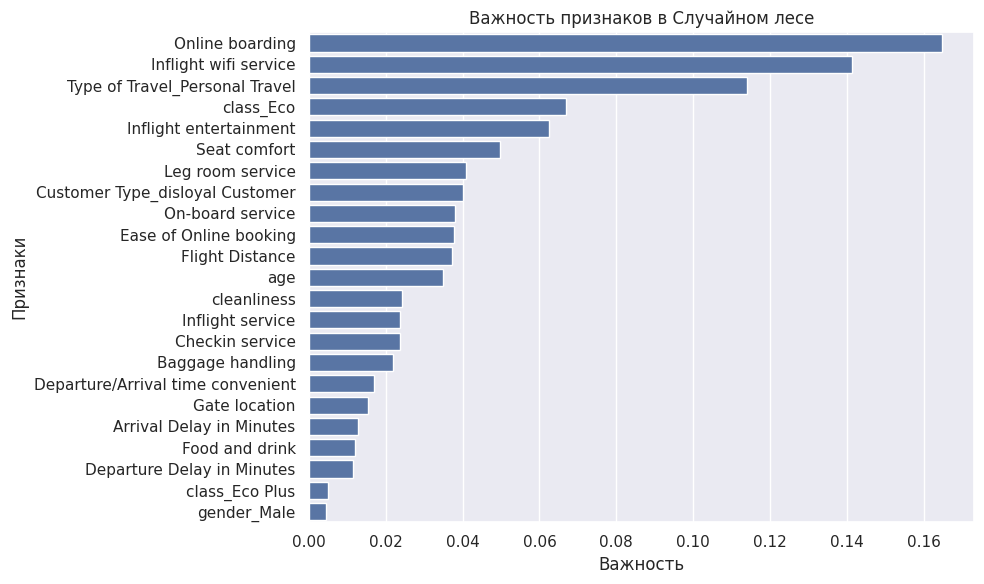

In [364]:
# random_forest = RandomForestClassifier(random_state=42)
# random_forest.fit(X_train, y_train)

feature_importances = random_forest.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков в Случайном лесе')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

In [365]:
print(most_important_features[:5])

['Online boarding', 'Inflight wifi service', 'Type of Travel_Personal Travel', 'Inflight entertainment', 'Customer Type_disloyal Customer']


Топ-3 признака для дерева решений и случайного леса совпадают, далее признаки имеют разную важность и отличаются.

In [366]:
with open('RF.pkl', 'wb') as f:
 pickle.dump(random_forest, f)

<Figure size 1000x800 with 0 Axes>

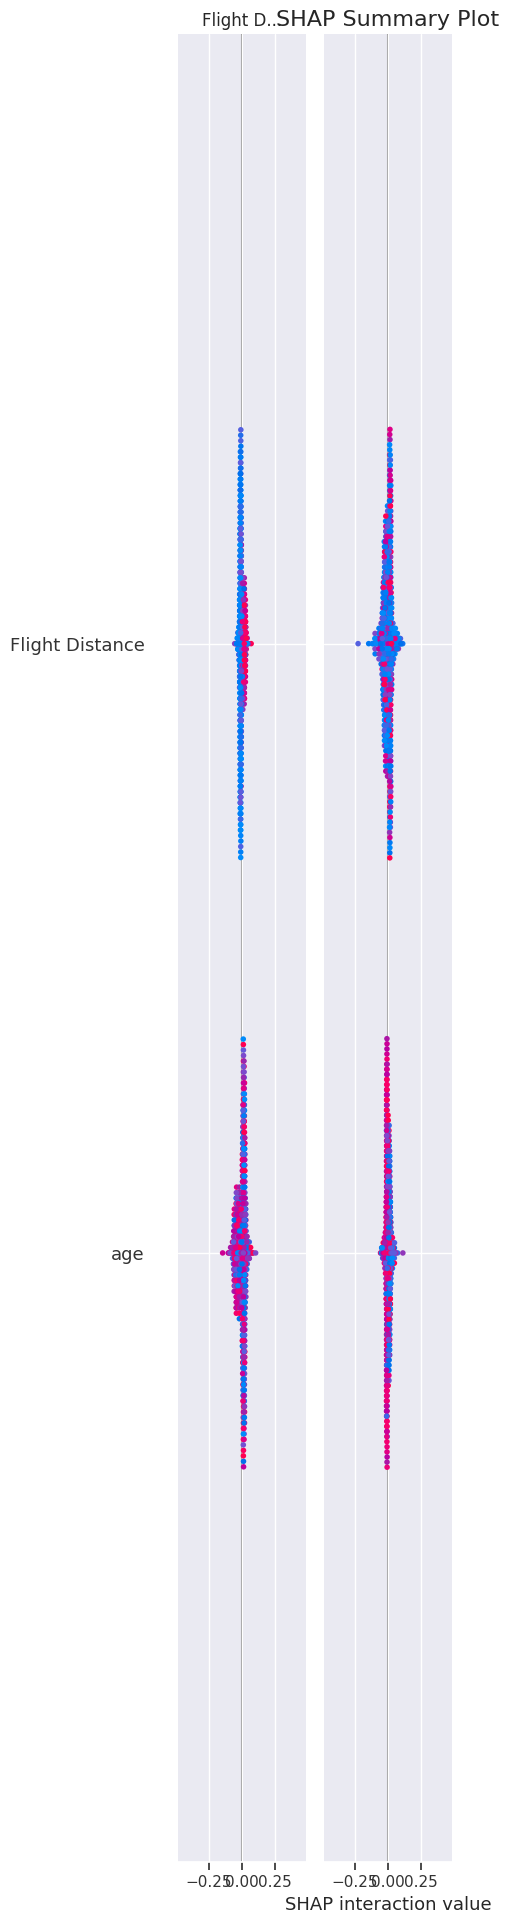

In [370]:
explainer = shap.TreeExplainer(random_forest)
df_sample = X_train.sample(1000, random_state=42)
shap_values = explainer.shap_values(df_sample)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    df_sample,
    feature_names=df_sample.columns,
    max_display=25,
    plot_type='bar',
    show=False
)

plt.title("SHAP Summary Plot", fontsize=16)
plt.tight_layout()
plt.show()

При низком age и высоком Flight Distance == молодые пассажиры на длинных рейсах, модель может предсказывать более высокую вероятность задержки.

При высоком age и низком Flight Distance ==пожилые пассажиры на коротких рейсах, модель может предсказывать более низкую вероятность задержки.

In [371]:
class_names = np.unique(y_train).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=class_names,
    discretize_continuous=True
)

observation = X_train.iloc[0, :]

explanation = explainer.explain_instance(
    data_row=observation.to_numpy(),
    predict_fn=best_model.predict_proba,
    num_features=10
)

explanation.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Оранжевые полосы показывают, как конкретные значения признаков увеличивают вероятность положительного класса. Синие полосы показывают, как конкретные значения признаков уменьшают вероятность положительного класса. Ну и как можно заметить, Online boarding уменьшает удовлетворенность полетом на 2%, а Inflight service увеличивает на 5%.